# L2HMC for $U(1)$ Gauge Model 

## Imports

In [1]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import i0, i1


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#from l2hmc_eager import dynamics_eager as _l2hmc
#from l2hmc_eager import gauge_dynamics_eager as l2hmc
#from l2hmc_eager.neural_nets import *
#from utils.distributions import GMM, gen_ring
#from utils.jacobian import _map, jacobian
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)
#from u1_model_eager import *

%autoreload 2

In [2]:
from l2hmc_eager import gauge_dynamics_eager as gde

Using TensorFlow backend.


In [3]:
#tf.enable_eager_execution()
tfe = tf.contrib.eager

In [5]:
from u1_model_eager import GaugeModelEager#, train_one_iter

In [8]:
from gauge_model import GaugeModel, graph_step, train_one_iter

In [9]:
from utils.gauge_model_helpers import plot_run_data

In [10]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result /= result[result.argmax()]
    return result[result.size//2:]

In [7]:
# To be defunnable, the function cannot return an Operation, so the above
# function is used for defun or eager, and this function is used in graph to be
# able to run the gradient updates.
def graph_step(dynamics, samples, optimizer, loss_fn, 
               params,  global_step=None, hmc=False):
    clip_value = params.get('clip_value', 100)
    loss, samples_out, accept_prob, grads = gde.loss_and_grads(
        dynamics=dynamics,
        x=samples,
        params=params,
        loss_fn=loss_fn,
        hmc=hmc
    )
    
    grads, _ = tf.clip_by_global_norm(grads, clip_value)
    train_op = optimizer.apply_gradients(
        zip(grads, dynamics.trainable_variables), global_step=global_step
    )
    
    return train_op, loss, samples_out, accept_prob, grads

#def graph_step(dynamics, optimizer, samples):
#  loss, grads, samples, _ = l2hmc.loss_and_grads(
#      dynamics, samples, loss_fn=l2hmc.compute_loss)
#  train_op = optimizer.apply_gradients(zip(grads, dynamics.variables))
#
#  return train_op, loss, samples

## Use GaugeModelEager for training L2HMC on $U(1)$ gauge lattice

### Define params

In [11]:
params = {
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'beta': 8.,
    'num_samples': 2,
    'num_steps': 5,
    'eps': 0.05,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
    'learning_rate_init': 1e-4,
    'learning_rate_decay_steps': 100,
    'learning_rate_decay_rate': 0.96,
    'train_steps': 1000,
    'record_loss_every': 50,
    'data_steps': 10,
    'save_steps': 50,
    'print_steps': 1,
    'logging_steps': 5,
    'clip_value': 100,
    'rand': False,
    'metric': 'l2',
}
tf.reset_default_graph()

In [18]:
tf.reset_default_graph()

In [19]:
model_conv = GaugeModel(params=params,
                        conv_net=True,
                        hmc=False,
                        log_dir=None,
                        restore=False)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_2/
################################################################################
Model parameters:
log_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_2/

info_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_2/run_info/

figs_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_2/figures/

conv_net: True

hmc: False

time_size: 8

space_size: 8

link_type: U1

dim: 2

beta: 8.0

num_samples: 2

num_steps: 5

eps: 0.05

loss_scale: 0.1

loss_eps: 0.0001

learning_rate_init: 0.0001

learning_rate_decay_steps: 100

learning_rate_decay_rate: 0.96

train_steps: 1000

record_loss_every: 50

data_steps: 10

save_steps: 50

print_steps: 1

logging_steps: 5

clip_value: 100

rand: False

metric: l2

batch_size: 2

################################################################################




In [20]:
model_conv.logging_steps = 50
model_conv.data_steps = 1 
model_conv.save_steps = 50

In [ ]:
model_conv.train(500)

Building graph...
done.

------------------------------------------------------------------------------------
    STEP        LOSS   TIME/STEP  ACCEPT %    EPS      ACTION    TOP Q      PLAQ   
------------------------------------------------------------------------------------
Starting training...

    STEP        LOSS   TIME/STEP  ACCEPT %    EPS      ACTION    TOP Q      PLAQ   
------------------------------------------------------------------------------------
    0/1000     -64.81      0       0.4615     0.05      12.2    0.001134   0.9762  


    STEP        LOSS   TIME/STEP  ACCEPT %    EPS      ACTION    TOP Q      PLAQ   
------------------------------------------------------------------------------------
    1/1000     -36.55    302.5     0.8457    0.0501    26.58    -0.01327   0.9481  


    2/1000     -77.12    28.48     0.9265    0.0502    29.98    0.06282    0.9414  


    3/1000     -50.8     34.45    0.09459   0.05029    29.98    0.06282    0.9414  


    4/1000     -5

In [17]:
%debug

> /Users/saforem2/ANL/l2hmc/l2hmc/gauge_model.py(475)train()
    473             params=self.params,
    474             global_step=self.global_step,
--> 475             hmc=self.hmc
    476         )
    477 

ipdb> hmc
*** NameError: name 'hmc' is not defined
ipdb> self.hmc
False
ipdb> self.params
{'time_size': 8, 'space_size': 8, 'link_type': 'U1', 'dim': 2, 'beta': 8.0, 'num_samples': 2, 'num_steps': 5, 'eps': 0.05, 'loss_scale': 0.1, 'loss_eps': 0.0001, 'learning_rate_init': 0.0001, 'learning_rate_decay_steps': 100, 'learning_rate_decay_rate': 0.96, 'train_steps': 1000, 'record_loss_every': 50, 'data_steps': 10, 'save_steps': 50, 'print_steps': 1, 'logging_steps': 5, 'clip_value': 100, 'rand': False, 'metric': 'l2'}
ipdb> args
self = <gauge_model.GaugeModel object at 0x12542b2e8>
num_train_steps = 500
keep_samples = False
config = None
ipdb> s


In [9]:
#model_conv = GaugeModelEager(params=params,
#                             conv_net=True,
#                             hmc=False,
#                             log_dir=None,
#                             restore=False,
#                             defun=False)
#
#model_conv.train(500, keep_samples=False)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_154/
total initialization time: 0.3937661647796631

################################################################################
Model parameters:
log_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_154/

info_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_154/run_info/

figs_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_154/figures/

_defun: False

conv_net: True

hmc: False

time_size: 8

space_size: 8

link_type: U1

dim: 2

beta: 8.0

num_samples: 2

num_steps: 5

eps: 0.05

loss_scale: 0.1

loss_eps: 0.0001

learning_rate_init: 0.0001

learning_rate_decay_steps: 100

learning_rate_decay_rate: 0.96

train_steps: 1000

record_loss_every: 50

data_steps: 10

save_steps: 50

print_steps: 1

logging_steps: 5

clip_value: 100

rand: False

metric: l2

batch_size: 2

################################################################################




In [14]:
tf.enable_resource_variables()
tf.reset_default_graph()
#with tf.Graph().as_default():
print("Building graph...")
model_conv = GaugeModelEager(params=params,
                             conv_net=True,
                             hmc=False,
                             log_dir=None,
                             restore=False,
                             defun=False)
x = tf.placeholder(tf.float32, shape=model_conv.samples.shape)
samples_np = np.array(model_conv.lattice.samples, dtype=np.float32)
#x = np.array(model_conv.lattice.samples, dtype=np.float32)
loss, _, _ = gde.compute_loss(model_conv.dynamics, x, model_conv.params)
train_op, loss, samples_out, accept_prob, _ = graph_step(
    dynamics=model_conv.dynamics,
    samples=x,
    optimizer=model_conv.optimizer,
    loss_fn=gde.compute_loss,
    params=model_conv.params,
    global_step=model_conv.global_step,
    hmc=model_conv.hmc
)
session_conf = tf.ConfigProto()
print("done.")

Building graph...
Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_147/
total initialization time: 0.13150906562805176

################################################################################
Model parameters:
log_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_147/

info_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_147/run_info/

figs_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_147/figures/

_defun: False

conv_net: True

hmc: False

time_size: 8

space_size: 8

link_type: U1

dim: 2

beta: 8.0

num_samples: 2

num_steps: 5

eps: 0.05

loss_scale: 0.1

loss_eps: 0.0001

learning_rate_init: 0.0001

learning_rate_decay_steps: 100

learning_rate_decay_rate: 0.96

train_steps: 1000

record_loss_every: 50

data_steps: 10

save_steps: 50

print_steps: 1

logging_steps: 5

clip_value: 100

rand: False

metric: l2

batch_size: 2

################################################################################


done.


In [15]:
#with tf.Session(config=session_conf) as sess:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
print("Performing warmup...")
for _ in range(1):
    _, _ = sess.run([train_op, loss], feed_dict={x: samples_np})
print("done.")
print("Training...")
start_time = time.time()
for i in range(10):
    _, loss_np, samples_np, accept_prob_np = sess.run(
        [train_op,
         loss,
         samples_out,
         accept_prob],
        feed_dict={x: samples_np}
    )
    print(f'step: {i}, loss: {loss_np}')
#x_, v_, x_accept_prob, x_out = model_conv.dynamics.apply_transition(x)

Performing warmup...
done.
Training...
step: 0, loss: -59.110755920410156
step: 1, loss: -59.755653381347656
step: 2, loss: -56.603111267089844
step: 3, loss: -66.47038269042969
step: 4, loss: -45.12910842895508
step: 5, loss: -65.19548797607422
step: 6, loss: -60.59280776977539
step: 7, loss: -72.49162292480469
step: 8, loss: -69.82719421386719
step: 9, loss: -56.065582275390625


In [16]:
sess.run(model_conv.dynamics.eps)

0.05106933

In [19]:
observables = model_conv.calc_observables(samples_np, _print=True, _write=True)

In [20]:
total_actions, avg_plaquettes, top_charges = observables

In [21]:
sess.run(total_actions[0])

30.551918

In [23]:
total_actions_arr = []
avg_plaquettes_arr = []
top_charges_arr = []
for i in range(model_conv.batch_size):
    ta_np, ap_np, tc_np = sess.run([total_actions[i], 
                                    avg_plaquettes[i], 
                                    top_charges[i]])
    total_actions_arr.append(ta_np)
    avg_plaquettes_arr.append(ap_np)
    top_charges_arr.append(tc_np)

In [25]:
total_actions_arr

[30.551918, 30.664919]

In [24]:
%debug

> <ipython-input-22-dd17190eead8>(4)<module>()
      2 avg_plaquettes_arr = []
      3 top_charges_arr = []
----> 4 for i in model_conv.batch_size:
      5     ta_np, ap_np, tc_np = sess.run([total_actions[i], 
      6                                     avg_plaquettes[i],

ipdb> q


In [14]:
%debug

> /Users/saforem2/Library/Python/3.6/lib/python/site-packages/tensorflow/python/eager/imperative_grad.py(63)imperative_grad()
     59      or if only non-differentiable functions of the source were used in the
     60      computation of target.
     61   """
     62   return pywrap_tensorflow.TFE_Py_TapeGradient(
---> 63       tape._tape, vspace, target, sources, output_gradients)  # pylint: disable=protected-access

ipdb> ll
     31 def imperative_grad(
     32     vspace,
     33     tape,
     34     target,
     35     sources,
     36     output_gradients=None):
     37   """Computes gradients from the imperatively defined tape on top of the stack.
     38 
     39   Works by filtering the tape, computing how many downstream usages are of each
     40   tensor and entry, and repeatedly applying backward functions until we have
     41   gradients for all sources.
     42 
     43   Args:
     44    vspace: the vector space in which to differentiate.
     45    tape: the gradient 

ipdb> loss_val
<tf.Tensor 'Mean_1:0' shape=() dtype=float32>
ipdb> dynamics.variables
[<tf.Variable 'XConvNet/conv_x1/kernel:0' shape=(3, 3, 2, 16) dtype=float32>, <tf.Variable 'XConvNet/conv_x1/bias:0' shape=(16,) dtype=float32>, <tf.Variable 'XConvNet/conv_v1/kernel:0' shape=(3, 3, 2, 16) dtype=float32>, <tf.Variable 'XConvNet/conv_v1/bias:0' shape=(16,) dtype=float32>, <tf.Variable 'XConvNet/conv_x2/kernel:0' shape=(2, 2, 16, 32) dtype=float32>, <tf.Variable 'XConvNet/conv_x2/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'XConvNet/conv_v2/kernel:0' shape=(2, 2, 16, 32) dtype=float32>, <tf.Variable 'XConvNet/conv_v2/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'XConvNet/v_layer/kernel:0' shape=(32, 256) dtype=float32>, <tf.Variable 'XConvNet/v_layer/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'XConvNet/x_layer/kernel:0' shape=(32, 256) dtype=float32>, <tf.Variable 'XConvNet/x_layer/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'XConvNet/t_layer/kernel:0' shape=(2, 25

In [ ]:
tf.reset_default_graph()
      with tf.Graph().as_default():
        energy_fn, _, _ = l2hmc.get_scg_energy_fn()
        x = tf.random_normal([hparams.n_samples, hparams.x_dim],
                             dtype=tf.float32)
        dynamics = l2hmc.Dynamics(
            x_dim=hparams.x_dim,
            minus_loglikelihood_fn=energy_fn,
            n_steps=hparams.n_steps,
            eps=hparams.eps)
        loss, _, _ = l2hmc.compute_loss(dynamics, x)
        optimizer = tf.train.AdamOptimizer(learning_rate=hparams.learning_rate)
        train_op, loss, _ = graph_step(dynamics, optimizer, x)
        # Single thread; fairer comparison against eager
        session_conf = tf.ConfigProto(inter_op_parallelism_threads=1)
        with tf.Session(config=session_conf) as sess:
          sess.run(tf.global_variables_initializer())

          # Warmup to reduce initialization effect when timing
          for _ in range(hparams.n_warmup_iters):
            _, _ = sess.run([train_op, loss])

          # Training
          start_time = time.time()
          for i in range(hparams.n_iters):
            _, loss_np = sess.run([train_op, loss])
            print("Iteration %d: loss %.4f" % (i, loss_np))

### Create model

#### (Generic) HMC Model

In [79]:
model_hmc = GaugeModelEager(params=params,
                            log_dir=None,
                            restore=False,
                            defun=True)
# 1m 22.9s

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_68/
Creating lattice...
done.
Creating dynamics...
done.
total initialization time: 0.12935495376586914

################################################################################
Model parameters:
log_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_68/

info_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_68/run_info/

figs_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_68/figures/

_defun: True

conv_net: False

time_size: 8

space_size: 8

link_type: U1

dim: 2

beta: 3.5

num_samples: 2

n_steps: 5

eps: 0.05

loss_scale: 0.1

loss_eps: 0.0001

learning_rate_init: 0.0001

learning_rate_decay_steps: 100

learning_rate_decay_rate: 0.96

train_steps: 1000

record_loss_every: 50

data_steps: 10

save_steps: 50

print_steps: 1

logging_steps: 5

clip_value: 100

rand: False

metric: l2

hmc: True

batch_size: 2

###############################################################################

In [80]:
observables_hmc = model_hmc.calc_observables(model_hmc.samples, 
                                             _print=True, 
                                             _write=True)
total_actions, avg_plaquettes, top_charges = observables_hmc

    STEP        LOSS   TIME/STEP  ACCEPT %    EPS      ACTION    TOP Q      PLAQ   
------------------------------------------------------------------------------------
    0/1000       0         0         0        0.05       0         0         1     




In [ ]:
model_hmc.train(500, keep_samples=False)

Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_65/figures/average_plaquettes_vs_step.pdf...
Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_65/figures/average_topological_charge_vs_step.pdf...
Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_65/figures/average_total_action_vs_step.pdf...
done.


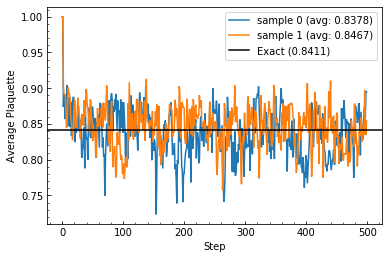

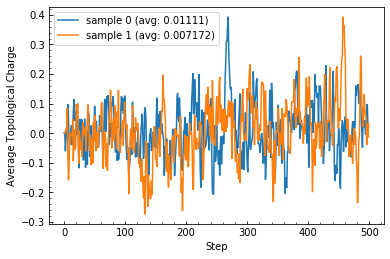

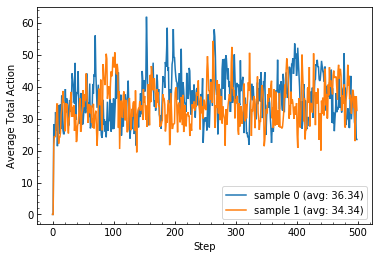

In [21]:
steps = np.arange(len(model_hmc.data['average_plaquettes_arr']))
_ = plot_run_data(model_hmc.data, model_hmc.params, 
                  steps, model_hmc.figs_dir, skip_steps=1)

#### ConvNet L2HMC Model

In [6]:
tf.reset_default_graph()

In [7]:
#params['conv_net'] = True
model_conv = GaugeModelEager(params=params,
                             conv_net=True,
                             hmc=False,
                             log_dir=None,
                             restore=False,
                             defun=False)
#model_conv.params

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_136/
Creating lattice...
done.
Creating dynamics...
done.
total initialization time: 0.050379037857055664

################################################################################
Model parameters:
log_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_136/

info_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_136/run_info/

figs_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_136/figures/

_defun: False

conv_net: True

hmc: False

time_size: 8

space_size: 8

link_type: U1

dim: 2

beta: 8.0

num_samples: 2

num_steps: 5

eps: 0.05

loss_scale: 0.1

loss_eps: 0.0001

learning_rate_init: 0.0001

learning_rate_decay_steps: 100

learning_rate_decay_rate: 0.96

train_steps: 1000

record_loss_every: 50

data_steps: 10

save_steps: 50

print_steps: 1

logging_steps: 5

clip_value: 100

rand: False

metric: l2

batch_size: 2

#######################################################################

In [8]:
observables_conv = model_conv.calc_observables(model_conv.samples, 
                                               _print=True, 
                                               _write=True)
total_actions, avg_plaquettes, top_charges = observables_conv

    STEP        LOSS   TIME/STEP  ACCEPT %    EPS      ACTION    TOP Q      PLAQ   
------------------------------------------------------------------------------------
    0/1000       0         0         0        0.05       0         0         1     




In [9]:
#start_step = model_conv.global_step.numpy()
#samples = model_conv.samples

#loss, samples, accept_prob, grads = train_one_iter(
#    dynamics=model_conv.dynamics,
#    samples=samples,
#    optimizer=model_conv.optimizer,
#    loss_fn=model_conv.loss_fn,
#    global_step=model_conv.global_step,
#    params=model_conv.params,
#    hmc=model_conv.hmc
#)

In [ ]:
model_conv.train(10, keep_samples=False)

Computing loss_and_grads...
Calculating loss_fn...
Running dynamics.apply_transition(x)...
	Running self.transition_kernel(position, forward=True)...
		 leapfrog step: 0
			 Running self._update_momentum_forward...
				 Running self.momentum_fn...
			 Running self._update_position_forward...
				 Running self.position_fn...
			 Running self._update_position_forward...
				 Running self.position_fn...
			 Running self._update_momentum_forward...
				 Running self.momentum_fn...
		 leapfrog step: 1
			 Running self._update_momentum_forward...
				 Running self.momentum_fn...
			 Running self._update_position_forward...
				 Running self.position_fn...
			 Running self._update_position_forward...
				 Running self.position_fn...
			 Running self._update_momentum_forward...
				 Running self.momentum_fn...
		 leapfrog step: 2
			 Running self._update_momentum_forward...
				 Running self.momentum_fn...
			 Running self._update_position_forward...
				 Running self.position_fn...
			 Runnin

				 Running self.momentum_fn...
		 leapfrog step: 2
			 Running self._update_momentum_forward...
				 Running self.momentum_fn...
			 Running self._update_position_forward...
				 Running self.position_fn...
			 Running self._update_position_forward...
				 Running self.position_fn...
			 Running self._update_momentum_forward...
				 Running self.momentum_fn...
		 leapfrog step: 3
			 Running self._update_momentum_forward...
				 Running self.momentum_fn...
			 Running self._update_position_forward...
				 Running self.position_fn...
			 Running self._update_position_forward...
				 Running self.position_fn...
			 Running self._update_momentum_forward...
				 Running self.momentum_fn...
		 leapfrog step: 4
			 Running self._update_momentum_forward...
				 Running self.momentum_fn...
			 Running self._update_position_forward...
				 Running self.position_fn...
			 Running self._update_position_forward...
				 Running self.position_fn...
			 Running self._update_momentum_forward...
				

				 Running self.momentum_fn...
	Running self.transition_kernel(position, forward=False)...
		 leapfrog step: 0
			 Running self._update_momentum_backward...
				 Running self.momentum_fn`...
			 Running self._update_position_backward...
				 Running self.position_fn...
			 Running self._update_position_backward...
				 Running self.position_fn...
			 Running self._update_momentum_backward...
				 Running self.momentum_fn`...
		 leapfrog step: 1
			 Running self._update_momentum_backward...
				 Running self.momentum_fn`...
			 Running self._update_position_backward...
				 Running self.position_fn...
			 Running self._update_position_backward...
				 Running self.position_fn...
			 Running self._update_momentum_backward...
				 Running self.momentum_fn`...
		 leapfrog step: 2
			 Running self._update_momentum_backward...
				 Running self.momentum_fn`...
			 Running self._update_position_backward...
				 Running self.position_fn...
			 Running self._update_position_backward...
				 R

Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_71/figures/average_plaquettes_vs_step.pdf...
Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_71/figures/average_topological_charge_vs_step.pdf...
Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_71/figures/average_total_action_vs_step.pdf...
done.


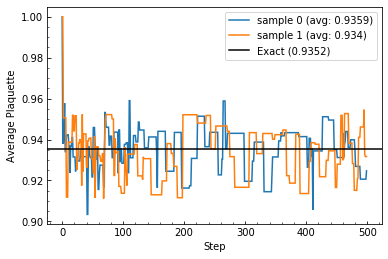

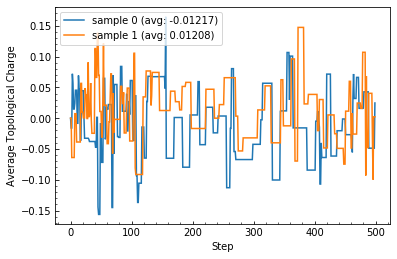

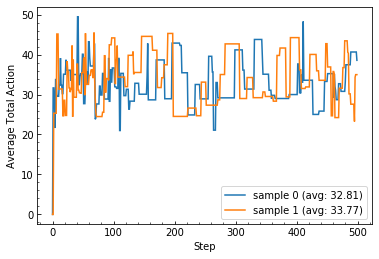

In [11]:
steps = np.arange(len(model_conv.data['average_plaquettes_arr']))
_ = plot_run_data(model_conv.data, model_conv.params, steps, 
                  model_conv.figs_dir, skip_steps=1)

#### FullyConnected (GenericNet) L2HMC Model

In [8]:
model_fc = GaugeModelEager(params=params,
                           log_dir=None,
                           restore=False,
                           defun=True)
model_fc.params

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_70/
Creating lattice...
done.
Creating dynamics...
done.
total initialization time: 0.047263145446777344

################################################################################
Model parameters:
log_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_70/

info_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_70/run_info/

figs_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_70/figures/

_defun: True

conv_net: False

time_size: 8

space_size: 8

link_type: U1

dim: 2

beta: 3.5

num_samples: 2

n_steps: 5

eps: 0.05

loss_scale: 0.1

loss_eps: 0.0001

learning_rate_init: 0.0001

learning_rate_decay_steps: 100

learning_rate_decay_rate: 0.96

train_steps: 1000

record_loss_every: 50

data_steps: 10

save_steps: 50

print_steps: 1

logging_steps: 5

clip_value: 100

rand: False

metric: l2

hmc: False

batch_size: 2

#############################################################################

{'time_size': 8,
 'space_size': 8,
 'link_type': 'U1',
 'dim': 2,
 'beta': 3.5,
 'num_samples': 2,
 'n_steps': 5,
 'eps': 0.05,
 'loss_scale': 0.1,
 'loss_eps': 0.0001,
 'learning_rate_init': 0.0001,
 'learning_rate_decay_steps': 100,
 'learning_rate_decay_rate': 0.96,
 'train_steps': 1000,
 'record_loss_every': 50,
 'data_steps': 10,
 'save_steps': 50,
 'print_steps': 1,
 'logging_steps': 5,
 'clip_value': 100,
 'rand': False,
 'metric': 'l2',
 'conv_net': False,
 'hmc': False}

In [9]:
observables_fc = model_fc.calc_observables(model_fc.samples, 
                                           _print=True, 
                                           _write=True)
total_actions, avg_plaquettes, top_charges = observables_fc

    STEP        LOSS   TIME/STEP  ACCEPT %    EPS      ACTION    TOP Q      PLAQ   
------------------------------------------------------------------------------------
    0/1000       0         0         0        0.05       0         0         1     




In [ ]:
model_fc.train(500, keep_samples=False)

In [23]:
#t0 = time.time()
#loss, samples, accept_prob, _ = train_one_iter(
#    dynamics=model.dynamics,
#    samples=model.samples,
#    optimizer=model.optimizer,
#    loss_fn=model.loss_fn,
#    params=model.params,
#    global_step=model.global_step,
#)
#print(f"Warmup time: {time.time() - t0}")

Warmup time: 3694.8429942131042


### Evaluate model (generate samples to measure Autocorrelation)

#### Using CONV NET model: `model_conv`

In [70]:
samples_conv = np.array(
    model_conv.lattice.samples.reshape((model_conv.batch_size, -1)),
    dtype=np.float32
)
apply_transition_conv = tfe.defun(model_conv.dynamics.apply_transition)

In [71]:
samples_conv = tf.random_normal(shape=model_conv.samples.shape)
samples_history_conv = []
actions_history_conv = []
avg_plaquettes_history_conv = []
top_charges_history_conv = []

In [72]:
for i in range(5000):
    samples_history_conv.append(samples_conv.numpy())
    t0 = time.time()
    _, _, _, samples_conv = apply_transition_conv(samples_conv)
    observables_conv = np.array(
        model_conv.lattice.calc_plaq_observables(samples_conv)
    ).T
    actions_history_conv.append(observables_conv[0])
    avg_plaquettes_history_conv.append(observables_conv[1])
    top_charges_history_conv.append(observables_conv[2])
    print(f'step: {i}  time/step: {time.time() - t0:^6.4g}')

step: 0  time/step: 187.4 
step: 1  time/step: 0.2608
step: 2  time/step: 0.3013
step: 3  time/step: 0.2845
step: 4  time/step: 0.2444
step: 5  time/step: 0.2476
step: 6  time/step: 0.2492
step: 7  time/step: 0.2537
step: 8  time/step: 0.2384
step: 9  time/step: 0.2286
step: 10  time/step: 0.2495
step: 11  time/step: 0.2747
step: 12  time/step: 0.2352
step: 13  time/step: 0.2426
step: 14  time/step: 0.2475
step: 15  time/step: 0.2517
step: 16  time/step: 0.2365
step: 17  time/step: 0.2428
step: 18  time/step: 0.2776
step: 19  time/step: 0.2757
step: 20  time/step: 0.2304
step: 21  time/step: 0.2424
step: 22  time/step: 0.2525
step: 23  time/step: 0.2516
step: 24  time/step: 0.2388
step: 25  time/step: 0.2417
step: 26  time/step: 0.2565
step: 27  time/step: 0.2514
step: 28  time/step: 0.2345
step: 29  time/step: 0.2437
step: 30  time/step: 0.2512
step: 31  time/step: 0.2476
step: 32  time/step: 0.2348
step: 33  time/step: 0.2435
step: 34  time/step: 0.2679
step: 35  time/step: 0.2771
st

step: 287  time/step: 0.2335
step: 288  time/step: 0.3005
step: 289  time/step: 0.2334
step: 290  time/step: 0.2404
step: 291  time/step: 0.2378
step: 292  time/step: 0.2582
step: 293  time/step: 0.2442
step: 294  time/step: 0.2428
step: 295  time/step: 0.236 
step: 296  time/step: 0.2542
step: 297  time/step: 0.2831
step: 298  time/step: 0.2392
step: 299  time/step: 0.2394
step: 300  time/step: 0.2505
step: 301  time/step: 0.2464
step: 302  time/step: 0.2355
step: 303  time/step: 0.2453
step: 304  time/step: 0.2506
step: 305  time/step: 0.2547
step: 306  time/step: 0.2335
step: 307  time/step: 0.2513
step: 308  time/step: 0.2841
step: 309  time/step: 0.2584
step: 310  time/step: 0.2328
step: 311  time/step: 0.248 
step: 312  time/step: 0.2568
step: 313  time/step: 0.2464
step: 314  time/step: 0.2376
step: 315  time/step: 0.2347
step: 316  time/step: 0.2934
step: 317  time/step: 0.2499
step: 318  time/step: 0.2378
step: 319  time/step: 0.238 
step: 320  time/step: 0.2603
step: 321  tim

step: 570  time/step: 0.2625
step: 571  time/step: 0.2654
step: 572  time/step: 0.2623
step: 573  time/step: 0.247 
step: 574  time/step: 0.2323
step: 575  time/step: 0.2737
step: 576  time/step: 0.2444
step: 577  time/step: 0.2609
step: 578  time/step: 0.2405
step: 579  time/step: 0.2395
step: 580  time/step: 0.2667
step: 581  time/step: 0.2238
step: 582  time/step: 0.2461
step: 583  time/step: 0.2531
step: 584  time/step: 0.269 
step: 585  time/step: 0.2538
step: 586  time/step: 0.2325
step: 587  time/step: 0.2932
step: 588  time/step: 0.2616
step: 589  time/step: 0.2379
step: 590  time/step: 0.2252
step: 591  time/step: 0.2377
step: 592  time/step: 0.2517
step: 593  time/step: 0.2383
step: 594  time/step: 0.2388
step: 595  time/step: 0.3101
step: 596  time/step: 0.2481
step: 597  time/step: 0.257 
step: 598  time/step: 0.2427
step: 599  time/step: 0.2605
step: 600  time/step: 0.2531
step: 601  time/step: 0.238 
step: 602  time/step: 0.2418
step: 603  time/step: 0.2817
step: 604  tim

step: 853  time/step: 0.3012
step: 854  time/step: 0.2815
step: 855  time/step: 0.3032
step: 856  time/step: 0.2781
step: 857  time/step: 0.4172
step: 858  time/step: 0.4489
step: 859  time/step: 0.3539
step: 860  time/step: 0.6345
step: 861  time/step: 0.3791
step: 862  time/step: 0.465 
step: 863  time/step: 0.3737
step: 864  time/step: 0.4821
step: 865  time/step: 0.368 
step: 866  time/step: 0.2573
step: 867  time/step: 0.3531
step: 868  time/step: 0.2963
step: 869  time/step: 0.2833
step: 870  time/step: 0.274 
step: 871  time/step: 0.3992
step: 872  time/step: 0.3281
step: 873  time/step: 0.3243
step: 874  time/step: 0.3035
step: 875  time/step: 0.3239
step: 876  time/step: 0.2939
step: 877  time/step: 0.3962
step: 878  time/step: 0.2889
step: 879  time/step: 0.2976
step: 880  time/step: 0.2845
step: 881  time/step: 0.3203
step: 882  time/step: 0.282 
step: 883  time/step: 0.2933
step: 884  time/step: 0.2859
step: 885  time/step: 0.287 
step: 886  time/step: 0.2766
step: 887  tim

step: 1131  time/step: 0.2739
step: 1132  time/step: 0.2492
step: 1133  time/step: 0.226 
step: 1134  time/step: 0.2357
step: 1135  time/step: 0.2348
step: 1136  time/step: 0.2639
step: 1137  time/step: 0.2323
step: 1138  time/step: 0.2469
step: 1139  time/step: 0.2316
step: 1140  time/step: 0.2608
step: 1141  time/step: 0.2385
step: 1142  time/step: 0.2373
step: 1143  time/step: 0.2395
step: 1144  time/step: 0.2505
step: 1145  time/step: 0.2458
step: 1146  time/step: 0.2379
step: 1147  time/step: 0.257 
step: 1148  time/step: 0.2602
step: 1149  time/step: 0.245 
step: 1150  time/step: 0.2382
step: 1151  time/step: 0.2442
step: 1152  time/step: 0.2796
step: 1153  time/step: 0.2435
step: 1154  time/step: 0.2327
step: 1155  time/step: 0.2369
step: 1156  time/step: 0.2505
step: 1157  time/step: 0.246 
step: 1158  time/step: 0.2437
step: 1159  time/step: 0.2348
step: 1160  time/step: 0.2564
step: 1161  time/step: 0.2469
step: 1162  time/step: 0.2406
step: 1163  time/step: 0.2372
step: 1164

step: 1405  time/step: 0.3671
step: 1406  time/step: 0.4045
step: 1407  time/step: 0.4813
step: 1408  time/step: 0.4223
step: 1409  time/step: 0.3346
step: 1410  time/step: 0.3293
step: 1411  time/step: 0.3316
step: 1412  time/step: 0.3912
step: 1413  time/step: 0.3508
step: 1414  time/step: 0.3823
step: 1415  time/step: 0.4077
step: 1416  time/step: 0.3897
step: 1417  time/step: 0.359 
step: 1418  time/step: 0.3584
step: 1419  time/step: 0.296 
step: 1420  time/step: 0.3307
step: 1421  time/step: 0.2328
step: 1422  time/step: 0.2394
step: 1423  time/step: 0.2356
step: 1424  time/step: 0.2552
step: 1425  time/step: 0.2522
step: 1426  time/step: 0.2437
step: 1427  time/step: 0.2496
step: 1428  time/step: 0.2542
step: 1429  time/step: 0.2627
step: 1430  time/step: 0.2394
step: 1431  time/step: 0.2508
step: 1432  time/step: 0.2929
step: 1433  time/step: 0.258 
step: 1434  time/step: 0.233 
step: 1435  time/step: 0.247 
step: 1436  time/step: 0.2612
step: 1437  time/step: 0.2434
step: 1438

step: 1679  time/step: 0.4024
step: 1680  time/step: 0.3067
step: 1681  time/step: 0.4813
step: 1682  time/step: 0.3021
step: 1683  time/step: 0.3662
step: 1684  time/step: 0.2614
step: 1685  time/step: 0.2548
step: 1686  time/step: 0.6052
step: 1687  time/step: 0.2768
step: 1688  time/step: 0.2397
step: 1689  time/step: 0.3292
step: 1690  time/step: 0.3108
step: 1691  time/step: 0.337 
step: 1692  time/step: 0.3925
step: 1693  time/step: 0.8156
step: 1694  time/step: 0.4628
step: 1695  time/step: 0.4428
step: 1696  time/step: 0.432 
step: 1697  time/step: 0.3645
step: 1698  time/step: 0.3744
step: 1699  time/step: 0.5394
step: 1700  time/step: 0.4446
step: 1701  time/step: 0.3807
step: 1702  time/step: 0.8217
step: 1703  time/step: 0.8379
step: 1704  time/step: 0.8061
step: 1705  time/step: 0.6196
step: 1706  time/step: 0.253 
step: 1707  time/step: 0.2417
step: 1708  time/step: 0.3077
step: 1709  time/step: 0.2661
step: 1710  time/step: 0.2679
step: 1711  time/step: 0.2966
step: 1712

step: 1953  time/step: 0.3357
step: 1954  time/step: 0.278 
step: 1955  time/step: 0.3144
step: 1956  time/step: 0.2756
step: 1957  time/step: 0.2667
step: 1958  time/step: 0.3346
step: 1959  time/step: 0.457 
step: 1960  time/step: 0.3534
step: 1961  time/step: 0.4894
step: 1962  time/step: 0.3696
step: 1963  time/step: 0.2588
step: 1964  time/step: 0.2666
step: 1965  time/step: 0.2986
step: 1966  time/step: 0.3004
step: 1967  time/step: 0.2994
step: 1968  time/step: 0.2665
step: 1969  time/step: 0.2757
step: 1970  time/step: 0.2823
step: 1971  time/step: 0.2954
step: 1972  time/step: 0.2608
step: 1973  time/step: 0.2808
step: 1974  time/step: 0.3028
step: 1975  time/step: 0.3193
step: 1976  time/step: 0.2657
step: 1977  time/step: 0.2747
step: 1978  time/step: 0.4096
step: 1979  time/step: 0.4817
step: 1980  time/step: 0.3708
step: 1981  time/step: 0.3622
step: 1982  time/step: 0.383 
step: 1983  time/step: 0.3469
step: 1984  time/step: 0.3025
step: 1985  time/step: 0.3447
step: 1986

step: 2227  time/step: 0.2748
step: 2228  time/step: 0.2679
step: 2229  time/step: 0.278 
step: 2230  time/step: 0.4656
step: 2231  time/step: 0.3828
step: 2232  time/step: 0.345 
step: 2233  time/step: 0.3264
step: 2234  time/step: 0.2467
step: 2235  time/step: 0.2516
step: 2236  time/step: 0.3069
step: 2237  time/step: 0.3828
step: 2238  time/step: 0.3473
step: 2239  time/step: 0.2652
step: 2240  time/step: 0.3396
step: 2241  time/step: 0.2929
step: 2242  time/step: 0.2442
step: 2243  time/step: 0.289 
step: 2244  time/step: 0.2519
step: 2245  time/step: 0.2318
step: 2246  time/step: 0.2466
step: 2247  time/step: 0.2507
step: 2248  time/step: 0.2516
step: 2249  time/step: 0.2546
step: 2250  time/step: 0.2601
step: 2251  time/step: 0.2816
step: 2252  time/step: 0.2704
step: 2253  time/step: 0.2474
step: 2254  time/step: 0.2428
step: 2255  time/step: 0.294 
step: 2256  time/step: 0.2431
step: 2257  time/step: 0.2529
step: 2258  time/step: 0.2588
step: 2259  time/step: 0.3517
step: 2260

step: 2501  time/step: 0.4276
step: 2502  time/step: 0.4789
step: 2503  time/step: 0.4152
step: 2504  time/step: 0.4249
step: 2505  time/step: 0.3923
step: 2506  time/step: 0.2915
step: 2507  time/step: 0.299 
step: 2508  time/step: 0.3549
step: 2509  time/step: 0.3601
step: 2510  time/step: 0.3955
step: 2511  time/step: 0.3749
step: 2512  time/step: 0.3393
step: 2513  time/step: 0.281 
step: 2514  time/step: 0.3441
step: 2515  time/step: 0.237 
step: 2516  time/step: 0.2278
step: 2517  time/step: 0.2402
step: 2518  time/step: 0.2584
step: 2519  time/step: 0.2371
step: 2520  time/step: 0.2361
step: 2521  time/step: 0.2503
step: 2522  time/step: 0.2822
step: 2523  time/step: 0.2313
step: 2524  time/step: 0.2378
step: 2525  time/step: 0.2791
step: 2526  time/step: 0.289 
step: 2527  time/step: 0.2585
step: 2528  time/step: 0.2925
step: 2529  time/step: 0.2734
step: 2530  time/step: 0.2469
step: 2531  time/step: 0.2767
step: 2532  time/step: 0.2778
step: 2533  time/step: 0.2612
step: 2534

step: 2775  time/step: 0.2428
step: 2776  time/step: 0.2718
step: 2777  time/step: 0.2892
step: 2778  time/step: 0.2603
step: 2779  time/step: 0.2634
step: 2780  time/step: 0.2963
step: 2781  time/step: 0.2541
step: 2782  time/step: 0.2837
step: 2783  time/step: 0.2572
step: 2784  time/step: 0.3034
step: 2785  time/step: 0.2383
step: 2786  time/step: 0.2396
step: 2787  time/step: 0.2714
step: 2788  time/step: 0.2645
step: 2789  time/step:  0.24 
step: 2790  time/step: 0.2365
step: 2791  time/step: 0.237 
step: 2792  time/step: 0.2852
step: 2793  time/step: 0.2705
step: 2794  time/step: 0.2651
step: 2795  time/step: 0.2624
step: 2796  time/step: 0.2667
step: 2797  time/step: 0.4095
step: 2798  time/step: 0.2792
step: 2799  time/step: 0.2858
step: 2800  time/step: 0.2515
step: 2801  time/step: 0.2556
step: 2802  time/step: 0.2668
step: 2803  time/step: 0.2679
step: 2804  time/step: 0.3398
step: 2805  time/step: 0.2884
step: 2806  time/step: 0.2994
step: 2807  time/step: 0.2406
step: 2808

step: 3049  time/step: 0.323 
step: 3050  time/step: 0.3378
step: 3051  time/step: 0.3562
step: 3052  time/step: 0.3743
step: 3053  time/step: 0.2421
step: 3054  time/step: 0.2265
step: 3055  time/step: 0.2407
step: 3056  time/step: 0.2584
step: 3057  time/step: 0.2482
step: 3058  time/step: 0.2395
step: 3059  time/step: 0.2375
step: 3060  time/step: 0.3338
step: 3061  time/step: 0.3032
step: 3062  time/step: 0.2393
step: 3063  time/step: 0.2696
step: 3064  time/step: 0.2395
step: 3065  time/step: 0.2435
step: 3066  time/step: 0.2436
step: 3067  time/step: 0.2558
step: 3068  time/step: 0.2529
step: 3069  time/step: 0.2513
step: 3070  time/step: 0.2642
step: 3071  time/step: 0.3169
step: 3072  time/step: 0.255 
step: 3073  time/step: 0.2533
step: 3074  time/step: 0.2336
step: 3075  time/step: 0.2653
step: 3076  time/step: 0.2554
step: 3077  time/step: 0.2684
step: 3078  time/step: 0.247 
step: 3079  time/step: 0.2527
step: 3080  time/step: 0.255 
step: 3081  time/step: 0.2533
step: 3082

step: 3323  time/step: 0.2521
step: 3324  time/step: 0.2347
step: 3325  time/step: 0.262 
step: 3326  time/step: 0.2472
step: 3327  time/step: 0.2947
step: 3328  time/step: 0.2525
step: 3329  time/step: 0.259 
step: 3330  time/step: 0.2954
step: 3331  time/step: 0.2369
step: 3332  time/step: 0.2341
step: 3333  time/step: 0.238 
step: 3334  time/step: 0.2543
step: 3335  time/step: 0.244 
step: 3336  time/step: 0.2379
step: 3337  time/step: 0.2402
step: 3338  time/step: 0.2486
step: 3339  time/step: 0.2845
step: 3340  time/step: 0.2449
step: 3341  time/step: 0.2416
step: 3342  time/step: 0.2532
step: 3343  time/step: 0.2462
step: 3344  time/step: 0.236 
step: 3345  time/step: 0.2397
step: 3346  time/step: 0.2484
step: 3347  time/step: 0.2463
step: 3348  time/step: 0.2402
step: 3349  time/step: 0.2368
step: 3350  time/step: 0.2815
step: 3351  time/step: 0.2467
step: 3352  time/step: 0.3145
step: 3353  time/step: 0.2474
step: 3354  time/step: 0.2984
step: 3355  time/step: 0.265 
step: 3356

step: 3597  time/step: 0.3005
step: 3598  time/step: 0.2431
step: 3599  time/step: 0.2368
step: 3600  time/step: 0.2332
step: 3601  time/step: 0.2481
step: 3602  time/step: 0.2458
step: 3603  time/step: 0.2367
step: 3604  time/step: 0.2409
step: 3605  time/step: 0.2551
step: 3606  time/step: 0.2486
step: 3607  time/step: 0.2375
step: 3608  time/step: 0.237 
step: 3609  time/step: 0.2847
step: 3610  time/step: 0.2455
step: 3611  time/step: 0.2317
step: 3612  time/step: 0.2378
step: 3613  time/step: 0.2571
step: 3614  time/step: 0.2837
step: 3615  time/step: 0.2341
step: 3616  time/step: 0.236 
step: 3617  time/step: 0.2515
step: 3618  time/step: 0.2462
step: 3619  time/step: 0.2355
step: 3620  time/step: 0.2318
step: 3621  time/step: 0.2536
step: 3622  time/step: 0.249 
step: 3623  time/step: 0.2301
step: 3624  time/step: 0.2626
step: 3625  time/step: 0.2397
step: 3626  time/step: 0.2418
step: 3627  time/step: 0.2368
step: 3628  time/step: 0.3088
step: 3629  time/step: 0.3542
step: 3630

step: 3871  time/step: 0.2411
step: 3872  time/step: 0.2932
step: 3873  time/step:  0.25 
step: 3874  time/step: 0.2391
step: 3875  time/step: 0.2393
step: 3876  time/step: 0.2494
step: 3877  time/step: 0.2491
step: 3878  time/step: 0.2348
step: 3879  time/step: 0.2391
step: 3880  time/step: 0.2433
step: 3881  time/step: 0.2765
step: 3882  time/step: 0.2497
step: 3883  time/step: 0.2382
step: 3884  time/step: 0.2539
step: 3885  time/step: 0.2481
step: 3886  time/step: 0.2366
step: 3887  time/step: 0.2404
step: 3888  time/step: 0.2428
step: 3889  time/step: 0.255 
step: 3890  time/step: 0.2365
step: 3891  time/step: 0.2348
step: 3892  time/step: 0.2697
step: 3893  time/step: 0.2617
step: 3894  time/step: 0.2322
step: 3895  time/step: 0.2378
step: 3896  time/step: 0.2409
step: 3897  time/step: 0.2614
step: 3898  time/step: 0.2343
step: 3899  time/step: 0.2402
step: 3900  time/step: 0.2367
step: 3901  time/step: 0.2567
step: 3902  time/step: 0.2402
step: 3903  time/step: 0.2383
step: 3904

step: 4145  time/step: 0.2392
step: 4146  time/step: 0.2459
step: 4147  time/step: 0.2649
step: 4148  time/step:  0.23 
step: 4149  time/step: 0.2597
step: 4150  time/step: 0.2717
step: 4151  time/step: 0.3085
step: 4152  time/step: 0.241 
step: 4153  time/step: 0.2584
step: 4154  time/step: 0.2614
step: 4155  time/step: 0.2525
step: 4156  time/step: 0.2716
step: 4157  time/step: 0.2625
step: 4158  time/step: 0.2636
step: 4159  time/step: 0.2603
step: 4160  time/step: 0.2479
step: 4161  time/step: 0.2407
step: 4162  time/step: 0.2583
step: 4163  time/step: 0.2635
step: 4164  time/step: 0.2569
step: 4165  time/step: 0.2423
step: 4166  time/step: 0.2691
step: 4167  time/step: 0.2466
step: 4168  time/step: 0.2535
step: 4169  time/step: 0.2626
step: 4170  time/step: 0.2828
step: 4171  time/step: 0.2432
step: 4172  time/step: 0.2634
step: 4173  time/step: 0.2448
step: 4174  time/step: 0.3017
step: 4175  time/step: 0.2523
step: 4176  time/step: 0.2451
step: 4177  time/step: 0.2772
step: 4178

step: 4419  time/step: 0.3491
step: 4420  time/step: 0.2685
step: 4421  time/step: 0.2757
step: 4422  time/step: 0.2571
step: 4423  time/step: 0.3025
step: 4424  time/step: 0.2727
step: 4425  time/step: 0.2347
step: 4426  time/step: 0.2706
step: 4427  time/step: 0.265 
step: 4428  time/step: 0.2646
step: 4429  time/step: 0.3093
step: 4430  time/step: 0.2529
step: 4431  time/step: 0.2516
step: 4432  time/step: 0.2517
step: 4433  time/step: 0.2529
step: 4434  time/step: 0.2779
step: 4435  time/step: 0.2925
step: 4436  time/step: 0.2353
step: 4437  time/step: 0.2557
step: 4438  time/step: 0.2517
step: 4439  time/step: 0.2253
step: 4440  time/step: 0.2378
step: 4441  time/step: 0.2655
step: 4442  time/step: 0.2464
step: 4443  time/step: 0.2325
step: 4444  time/step: 0.2411
step: 4445  time/step: 0.3512
step: 4446  time/step: 0.2425
step: 4447  time/step: 0.2377
step: 4448  time/step: 0.2348
step: 4449  time/step: 0.2769
step: 4450  time/step: 0.2516
step: 4451  time/step: 0.2431
step: 4452

step: 4693  time/step: 0.2456
step: 4694  time/step: 0.2865
step: 4695  time/step: 0.2598
step: 4696  time/step: 0.2537
step: 4697  time/step: 0.2445
step: 4698  time/step: 0.2635
step: 4699  time/step: 0.2522
step: 4700  time/step: 0.2393
step: 4701  time/step: 0.2367
step: 4702  time/step: 0.3302
step: 4703  time/step: 0.2949
step: 4704  time/step: 0.3039
step: 4705  time/step: 0.3297
step: 4706  time/step: 0.2954
step: 4707  time/step: 0.2852
step: 4708  time/step: 0.285 
step: 4709  time/step: 0.2576
step: 4710  time/step: 0.2262
step: 4711  time/step: 0.2539
step: 4712  time/step: 0.2928
step: 4713  time/step: 0.3268
step: 4714  time/step: 0.2836
step: 4715  time/step: 0.264 
step: 4716  time/step: 0.2966
step: 4717  time/step: 0.2904
step: 4718  time/step: 0.266 
step: 4719  time/step: 0.2917
step: 4720  time/step: 0.2519
step: 4721  time/step: 0.2503
step: 4722  time/step: 0.2396
step: 4723  time/step: 0.2486
step: 4724  time/step: 0.2509
step: 4725  time/step: 0.2374
step: 4726

step: 4967  time/step: 0.2329
step: 4968  time/step: 0.2359
step: 4969  time/step: 0.2416
step: 4970  time/step: 0.2527
step: 4971  time/step: 0.2398
step: 4972  time/step: 0.237 
step: 4973  time/step: 0.2323
step: 4974  time/step: 0.255 
step: 4975  time/step: 0.2376
step: 4976  time/step: 0.2344
step: 4977  time/step: 0.2551
step: 4978  time/step: 0.2578
step: 4979  time/step: 0.2408
step: 4980  time/step: 0.2395
step: 4981  time/step: 0.2428
step: 4982  time/step: 0.2857
step: 4983  time/step: 0.2356
step: 4984  time/step: 0.2335
step: 4985  time/step: 0.2326
step: 4986  time/step: 0.2515
step: 4987  time/step: 0.2471
step: 4988  time/step: 0.2354
step: 4989  time/step: 0.2329
step: 4990  time/step: 0.2477
step: 4991  time/step: 0.248 
step: 4992  time/step: 0.2378
step: 4993  time/step: 0.2399
step: 4994  time/step: 0.2472
step: 4995  time/step: 0.2478
step: 4996  time/step: 0.2306
step: 4997  time/step: 0.237 
step: 4998  time/step: 0.2457
step: 4999  time/step: 0.2488


In [74]:
samples_history_conv = np.array(samples_history_conv)
actions_history_conv = np.array(actions_history_conv)
avg_plaquettes_history_conv = np.array(avg_plaquettes_history_conv)
top_charges_history_conv = np.array(top_charges_history_conv)

#### Using HMC model: `model_hmc`

In [22]:
samples_hmc = np.array(
    model_hmc.lattice.samples.reshape((model_hmc.batch_size, -1)),
    dtype=np.float32
)
apply_transition_hmc = tfe.defun(model_hmc.dynamics.apply_transition)

In [23]:
samples_hmc = tf.random_normal(shape=model_hmc.samples.shape)
samples_history_hmc = []
actions_history_hmc = []
avg_plaquettes_history_hmc = []
top_charges_history_hmc = []

In [25]:
for i in range(5000):
    samples_history_hmc.append(samples_hmc.numpy())
    t0 = time.time()
    _, _, _, samples_hmc = apply_transition_hmc(samples_hmc)
    observables_hmc = np.array(
        model_hmc.lattice.calc_plaq_observables(samples_hmc)
    ).T
    actions_history_hmc.append(observables_hmc[0])
    avg_plaquettes_history_hmc.append(observables_hmc[1])
    top_charges_history_hmc.append(observables_hmc[2])
    print(f'step: {i}  time/step: {time.time() - t0:^6.4g}')

step: 0  time/step: 233.6 
step: 1  time/step: 0.3262
step: 2  time/step: 0.3071
step: 3  time/step: 0.2557
step: 4  time/step: 0.3789
step: 5  time/step: 0.3729
step: 6  time/step: 0.2581
step: 7  time/step: 0.3357
step: 8  time/step: 0.2648
step: 9  time/step: 0.2449
step: 10  time/step: 0.2636
step: 11  time/step: 0.2869
step: 12  time/step: 0.2621
step: 13  time/step: 0.2738
step: 14  time/step: 0.339 
step: 15  time/step: 0.3142
step: 16  time/step: 0.4949
step: 17  time/step: 0.3478
step: 18  time/step: 0.3892
step: 19  time/step: 0.3432
step: 20  time/step: 0.5953
step: 21  time/step: 0.3679
step: 22  time/step: 0.2782
step: 23  time/step: 0.3472
step: 24  time/step: 0.4498
step: 25  time/step: 0.2847
step: 26  time/step: 0.3384
step: 27  time/step: 0.2497
step: 28  time/step: 0.2942
step: 29  time/step: 0.2477
step: 30  time/step: 0.2619
step: 31  time/step: 0.2584
step: 32  time/step: 0.2773
step: 33  time/step: 0.249 
step: 34  time/step: 0.2596
step: 35  time/step: 0.2721
st

step: 287  time/step: 0.2646
step: 288  time/step: 0.264 
step: 289  time/step: 0.2383
step: 290  time/step: 0.2188
step: 291  time/step: 0.3365
step: 292  time/step: 0.2536
step: 293  time/step: 0.2366
step: 294  time/step: 0.2895
step: 295  time/step: 0.2738
step: 296  time/step: 0.2299
step: 297  time/step: 0.2296
step: 298  time/step: 0.2427
step: 299  time/step: 0.2651
step: 300  time/step: 0.3195
step: 301  time/step: 0.2919
step: 302  time/step: 0.3366
step: 303  time/step: 0.3156
step: 304  time/step: 0.2299
step: 305  time/step: 0.2479
step: 306  time/step: 0.3336
step: 307  time/step: 0.2487
step: 308  time/step: 0.2545
step: 309  time/step: 0.3091
step: 310  time/step: 0.2889
step: 311  time/step: 0.2991
step: 312  time/step: 0.2484
step: 313  time/step: 0.3003
step: 314  time/step: 0.2498
step: 315  time/step: 0.2605
step: 316  time/step: 0.2312
step: 317  time/step: 0.2468
step: 318  time/step: 0.2834
step: 319  time/step: 0.2178
step: 320  time/step: 0.219 
step: 321  tim

step: 570  time/step: 0.3341
step: 571  time/step: 0.2591
step: 572  time/step: 0.2822
step: 573  time/step: 0.2385
step: 574  time/step: 0.2858
step: 575  time/step: 0.2775
step: 576  time/step: 0.2337
step: 577  time/step: 0.217 
step: 578  time/step: 0.2736
step: 579  time/step: 0.254 
step: 580  time/step: 0.2258
step: 581  time/step: 0.2509
step: 582  time/step: 0.3145
step: 583  time/step: 0.283 
step: 584  time/step: 0.2206
step: 585  time/step: 0.2544
step: 586  time/step: 0.2481
step: 587  time/step: 0.2171
step: 588  time/step: 0.2815
step: 589  time/step: 0.2444
step: 590  time/step: 0.2672
step: 591  time/step: 0.262 
step: 592  time/step: 0.2601
step: 593  time/step: 0.3304
step: 594  time/step: 0.2856
step: 595  time/step: 0.2156
step: 596  time/step: 0.2301
step: 597  time/step: 0.2455
step: 598  time/step: 0.2846
step: 599  time/step: 0.2394
step: 600  time/step: 0.2295
step: 601  time/step: 0.2459
step: 602  time/step: 0.2606
step: 603  time/step: 0.2387
step: 604  tim

step: 853  time/step: 0.2952
step: 854  time/step: 0.2344
step: 855  time/step: 0.2704
step: 856  time/step: 0.2443
step: 857  time/step: 0.239 
step: 858  time/step: 0.2264
step: 859  time/step: 0.2621
step: 860  time/step: 0.2661
step: 861  time/step: 0.2445
step: 862  time/step: 0.2252
step: 863  time/step: 0.2412
step: 864  time/step: 0.2654
step: 865  time/step: 0.2294
step: 866  time/step: 0.2252
step: 867  time/step: 0.2702
step: 868  time/step: 0.2311
step: 869  time/step: 0.2141
step: 870  time/step: 0.2607
step: 871  time/step: 0.2702
step: 872  time/step: 0.2573
step: 873  time/step: 0.2394
step: 874  time/step: 0.2596
step: 875  time/step: 0.2514
step: 876  time/step: 0.242 
step: 877  time/step: 0.2178
step: 878  time/step: 0.2509
step: 879  time/step: 0.2502
step: 880  time/step: 0.2376
step: 881  time/step: 0.2464
step: 882  time/step: 0.2153
step: 883  time/step: 0.2594
step: 884  time/step: 0.2426
step: 885  time/step: 0.2315
step: 886  time/step: 0.2398
step: 887  tim

step: 1131  time/step: 0.2939
step: 1132  time/step: 0.2936
step: 1133  time/step: 0.3556
step: 1134  time/step: 0.2495
step: 1135  time/step: 0.2763
step: 1136  time/step: 0.2635
step: 1137  time/step: 0.4253
step: 1138  time/step: 0.2445
step: 1139  time/step: 0.3187
step: 1140  time/step: 0.325 
step: 1141  time/step: 0.3264
step: 1142  time/step: 0.523 
step: 1143  time/step: 0.3676
step: 1144  time/step: 0.2708
step: 1145  time/step: 0.3787
step: 1146  time/step: 0.4915
step: 1147  time/step: 0.2454
step: 1148  time/step: 0.2459
step: 1149  time/step: 0.2458
step: 1150  time/step: 0.3052
step: 1151  time/step: 0.4445
step: 1152  time/step: 0.2231
step: 1153  time/step: 0.2176
step: 1154  time/step: 0.2251
step: 1155  time/step: 0.2526
step: 1156  time/step: 0.229 
step: 1157  time/step: 0.2302
step: 1158  time/step: 0.272 
step: 1159  time/step: 0.3202
step: 1160  time/step: 0.2277
step: 1161  time/step: 0.3325
step: 1162  time/step: 0.4939
step: 1163  time/step: 0.2473
step: 1164

step: 1405  time/step: 0.3878
step: 1406  time/step: 0.3697
step: 1407  time/step: 0.4687
step: 1408  time/step: 0.4351
step: 1409  time/step: 0.4051
step: 1410  time/step: 0.3643
step: 1411  time/step: 0.3151
step: 1412  time/step: 0.5246
step: 1413  time/step: 0.3601
step: 1414  time/step: 0.3038
step: 1415  time/step: 0.5595
step: 1416  time/step: 0.3598
step: 1417  time/step: 0.6045
step: 1418  time/step: 0.316 
step: 1419  time/step: 0.3097
step: 1420  time/step: 0.3464
step: 1421  time/step: 0.2879
step: 1422  time/step: 0.2554
step: 1423  time/step: 0.307 
step: 1424  time/step: 0.2885
step: 1425  time/step: 0.2499
step: 1426  time/step: 0.2419
step: 1427  time/step: 0.3079
step: 1428  time/step: 0.2567
step: 1429  time/step: 0.2421
step: 1430  time/step: 0.3252
step: 1431  time/step: 0.2853
step: 1432  time/step: 0.3057
step: 1433  time/step: 0.2633
step: 1434  time/step: 0.2802
step: 1435  time/step: 0.2535
step: 1436  time/step: 0.2963
step: 1437  time/step: 0.3577
step: 1438

step: 1679  time/step: 0.435 
step: 1680  time/step: 0.3067
step: 1681  time/step: 0.2738
step: 1682  time/step: 0.3324
step: 1683  time/step: 0.2317
step: 1684  time/step: 0.3139
step: 1685  time/step: 0.3527
step: 1686  time/step: 0.4445
step: 1687  time/step: 0.3806
step: 1688  time/step: 0.4247
step: 1689  time/step: 0.3259
step: 1690  time/step: 0.3371
step: 1691  time/step: 0.3689
step: 1692  time/step: 0.2986
step: 1693  time/step: 0.3008
step: 1694  time/step: 0.3504
step: 1695  time/step: 0.3538
step: 1696  time/step: 0.485 
step: 1697  time/step: 0.7815
step: 1698  time/step: 0.5204
step: 1699  time/step: 0.3236
step: 1700  time/step: 0.3498
step: 1701  time/step: 0.3487
step: 1702  time/step: 0.4003
step: 1703  time/step: 0.3494
step: 1704  time/step: 0.3263
step: 1705  time/step: 0.3176
step: 1706  time/step: 0.3237
step: 1707  time/step: 0.3918
step: 1708  time/step: 0.2854
step: 1709  time/step: 0.2682
step: 1710  time/step: 0.2418
step: 1711  time/step: 0.2212
step: 1712

step: 1953  time/step: 0.3313
step: 1954  time/step: 0.4493
step: 1955  time/step: 0.3019
step: 1956  time/step: 0.3121
step: 1957  time/step: 0.383 
step: 1958  time/step: 0.365 
step: 1959  time/step: 0.342 
step: 1960  time/step: 0.3706
step: 1961  time/step: 0.3697
step: 1962  time/step: 0.3362
step: 1963  time/step: 0.3074
step: 1964  time/step: 0.2536
step: 1965  time/step: 0.2706
step: 1966  time/step: 0.2974
step: 1967  time/step: 0.242 
step: 1968  time/step: 0.2705
step: 1969  time/step: 0.2813
step: 1970  time/step: 0.2739
step: 1971  time/step: 0.2971
step: 1972  time/step: 0.2421
step: 1973  time/step: 0.2912
step: 1974  time/step: 0.3261
step: 1975  time/step: 0.2356
step: 1976  time/step: 0.2384
step: 1977  time/step: 0.2967
step: 1978  time/step: 0.2379
step: 1979  time/step: 0.2697
step: 1980  time/step: 0.2287
step: 1981  time/step: 0.2695
step: 1982  time/step: 0.2267
step: 1983  time/step: 0.2218
step: 1984  time/step: 0.2242
step: 1985  time/step: 0.248 
step: 1986

step: 2227  time/step: 0.2466
step: 2228  time/step: 0.3019
step: 2229  time/step: 0.2173
step: 2230  time/step: 0.2439
step: 2231  time/step: 0.2311
step: 2232  time/step: 0.2548
step: 2233  time/step: 0.2595
step: 2234  time/step: 0.2229
step: 2235  time/step: 0.2194
step: 2236  time/step: 0.3545
step: 2237  time/step: 0.2604
step: 2238  time/step: 0.2282
step: 2239  time/step: 0.2643
step: 2240  time/step: 0.2582
step: 2241  time/step: 0.2385
step: 2242  time/step: 0.2768
step: 2243  time/step: 0.3335
step: 2244  time/step: 0.2645
step: 2245  time/step: 0.2178
step: 2246  time/step: 0.2855
step: 2247  time/step: 0.2698
step: 2248  time/step: 0.2343
step: 2249  time/step: 0.2198
step: 2250  time/step: 0.2161
step: 2251  time/step: 0.2477
step: 2252  time/step: 0.2441
step: 2253  time/step: 0.3161
step: 2254  time/step: 0.2702
step: 2255  time/step: 0.5087
step: 2256  time/step: 0.6416
step: 2257  time/step: 0.378 
step: 2258  time/step: 0.429 
step: 2259  time/step: 0.4075
step: 2260

step: 2501  time/step: 0.3782
step: 2502  time/step: 0.5601
step: 2503  time/step: 0.386 
step: 2504  time/step: 0.6193
step: 2505  time/step: 0.5091
step: 2506  time/step: 0.4873
step: 2507  time/step: 0.4012
step: 2508  time/step: 0.4858
step: 2509  time/step: 0.4542
step: 2510  time/step: 0.388 
step: 2511  time/step: 0.3728
step: 2512  time/step: 0.3681
step: 2513  time/step: 0.5794
step: 2514  time/step: 0.6171
step: 2515  time/step: 0.6683
step: 2516  time/step: 0.6507
step: 2517  time/step: 0.3933
step: 2518  time/step: 0.4984
step: 2519  time/step: 0.437 
step: 2520  time/step: 0.3982
step: 2521  time/step: 0.7916
step: 2522  time/step: 0.8972
step: 2523  time/step: 0.7409
step: 2524  time/step: 0.5265
step: 2525  time/step: 0.5808
step: 2526  time/step: 0.414 
step: 2527  time/step: 0.3943
step: 2528  time/step: 0.5122
step: 2529  time/step: 0.4204
step: 2530  time/step: 0.3711
step: 2531  time/step: 0.3906
step: 2532  time/step: 0.3683
step: 2533  time/step: 0.3694
step: 2534

step: 2775  time/step: 0.3922
step: 2776  time/step: 0.4667
step: 2777  time/step: 0.3753
step: 2778  time/step: 0.4439
step: 2779  time/step: 0.5005
step: 2780  time/step: 0.4192
step: 2781  time/step: 0.4257
step: 2782  time/step: 0.565 
step: 2783  time/step: 0.4488
step: 2784  time/step: 0.6976
step: 2785  time/step: 0.8829
step: 2786  time/step: 1.309 
step: 2787  time/step: 0.5896
step: 2788  time/step: 0.3929
step: 2789  time/step: 0.434 
step: 2790  time/step: 0.5891
step: 2791  time/step: 0.4562
step: 2792  time/step: 0.4712
step: 2793  time/step: 0.3809
step: 2794  time/step: 0.5034
step: 2795  time/step: 0.3972
step: 2796  time/step: 0.3846
step: 2797  time/step: 0.4765
step: 2798  time/step: 0.3974
step: 2799  time/step: 0.5254
step: 2800  time/step: 0.5459
step: 2801  time/step: 0.5092
step: 2802  time/step: 0.3976
step: 2803  time/step: 0.5195
step: 2804  time/step: 0.4207
step: 2805  time/step: 0.4474
step: 2806  time/step: 0.414 
step: 2807  time/step: 0.3555
step: 2808

step: 3049  time/step: 0.431 
step: 3050  time/step: 0.5999
step: 3051  time/step: 0.4609
step: 3052  time/step: 0.3865
step: 3053  time/step: 0.3709
step: 3054  time/step: 0.3875
step: 3055  time/step: 0.3944
step: 3056  time/step: 0.3716
step: 3057  time/step: 0.4535
step: 3058  time/step: 0.476 
step: 3059  time/step: 0.3492
step: 3060  time/step: 0.4155
step: 3061  time/step: 0.4305
step: 3062  time/step: 0.6009
step: 3063  time/step: 0.6899
step: 3064  time/step: 0.6145
step: 3065  time/step: 0.684 
step: 3066  time/step: 0.3875
step: 3067  time/step: 0.393 
step: 3068  time/step: 0.3838
step: 3069  time/step: 0.3611
step: 3070  time/step: 0.4567
step: 3071  time/step: 0.3768
step: 3072  time/step: 0.3769
step: 3073  time/step: 0.4125
step: 3074  time/step: 0.3592
step: 3075  time/step: 0.4264
step: 3076  time/step: 0.3808
step: 3077  time/step: 0.3816
step: 3078  time/step: 0.4083
step: 3079  time/step: 0.3685
step: 3080  time/step: 0.4445
step: 3081  time/step: 0.383 
step: 3082

step: 3323  time/step: 0.2887
step: 3324  time/step: 0.2462
step: 3325  time/step: 0.3495
step: 3326  time/step: 0.2671
step: 3327  time/step: 0.2585
step: 3328  time/step: 0.2415
step: 3329  time/step: 0.4113
step: 3330  time/step: 0.3699
step: 3331  time/step: 0.3986
step: 3332  time/step: 0.3906
step: 3333  time/step: 0.3576
step: 3334  time/step: 0.391 
step: 3335  time/step: 0.3652
step: 3336  time/step: 0.3557
step: 3337  time/step: 0.4048
step: 3338  time/step: 0.3645
step: 3339  time/step: 0.4304
step: 3340  time/step: 0.3778
step: 3341  time/step: 0.4017
step: 3342  time/step: 0.4505
step: 3343  time/step: 0.401 
step: 3344  time/step: 0.4199
step: 3345  time/step: 0.3856
step: 3346  time/step: 0.4901
step: 3347  time/step: 0.4102
step: 3348  time/step: 0.3575
step: 3349  time/step: 0.4332
step: 3350  time/step: 0.3639
step: 3351  time/step: 0.4684
step: 3352  time/step: 0.3678
step: 3353  time/step: 0.3678
step: 3354  time/step: 0.3907
step: 3355  time/step: 0.3652
step: 3356

step: 3597  time/step: 0.5191
step: 3598  time/step: 0.4221
step: 3599  time/step: 0.6566
step: 3600  time/step: 0.4424
step: 3601  time/step: 0.4381
step: 3602  time/step: 0.3635
step: 3603  time/step: 0.385 
step: 3604  time/step: 0.3873
step: 3605  time/step: 0.3537
step: 3606  time/step: 0.4148
step: 3607  time/step: 0.3735
step: 3608  time/step: 0.3828
step: 3609  time/step: 0.4143
step: 3610  time/step: 0.3716
step: 3611  time/step: 0.4584
step: 3612  time/step: 0.3733
step: 3613  time/step: 0.3835
step: 3614  time/step: 0.4267
step: 3615  time/step: 0.371 
step: 3616  time/step: 0.3833
step: 3617  time/step: 0.3787
step: 3618  time/step: 0.3573
step: 3619  time/step: 0.5297
step: 3620  time/step: 0.3891
step: 3621  time/step: 0.4662
step: 3622  time/step: 0.785 
step: 3623  time/step: 0.5017
step: 3624  time/step: 0.4107
step: 3625  time/step: 0.4092
step: 3626  time/step: 0.4544
step: 3627  time/step: 0.404 
step: 3628  time/step: 0.3749
step: 3629  time/step: 0.4001
step: 3630

step: 3871  time/step: 0.6848
step: 3872  time/step: 0.5832
step: 3873  time/step: 0.6054
step: 3874  time/step: 0.8219
step: 3875  time/step: 0.6441
step: 3876  time/step: 0.6496
step: 3877  time/step: 0.6958
step: 3878  time/step: 0.5696
step: 3879  time/step: 0.5515
step: 3880  time/step: 0.3556
step: 3881  time/step: 0.3838
step: 3882  time/step: 0.3782
step: 3883  time/step: 0.4356
step: 3884  time/step: 0.4241
step: 3885  time/step: 0.3643
step: 3886  time/step: 0.3837
step: 3887  time/step: 0.3828
step: 3888  time/step: 0.403 
step: 3889  time/step: 0.6573
step: 3890  time/step: 0.6753
step: 3891  time/step: 0.5883
step: 3892  time/step: 0.6731
step: 3893  time/step: 0.6504
step: 3894  time/step: 0.6633
step: 3895  time/step: 0.5569
step: 3896  time/step: 0.5124
step: 3897  time/step: 0.6282
step: 3898  time/step: 0.5776
step: 3899  time/step: 0.5328
step: 3900  time/step: 0.6852
step: 3901  time/step: 0.5862
step: 3902  time/step: 0.5921
step: 3903  time/step: 0.5296
step: 3904

step: 4145  time/step: 0.6249
step: 4146  time/step: 0.658 
step: 4147  time/step: 0.3881
step: 4148  time/step: 0.4069
step: 4149  time/step: 0.4725
step: 4150  time/step: 0.3654
step: 4151  time/step: 0.4575
step: 4152  time/step: 0.6283
step: 4153  time/step: 0.4032
step: 4154  time/step: 0.3797
step: 4155  time/step: 0.3719
step: 4156  time/step: 0.417 
step: 4157  time/step: 0.4185
step: 4158  time/step: 0.5511
step: 4159  time/step: 0.5914
step: 4160  time/step: 0.6913
step: 4161  time/step: 0.5368
step: 4162  time/step: 0.5036
step: 4163  time/step: 0.3599
step: 4164  time/step: 0.4111
step: 4165  time/step: 0.3616
step: 4166  time/step: 0.3732
step: 4167  time/step: 0.4098
step: 4168  time/step: 0.505 
step: 4169  time/step: 0.5548
step: 4170  time/step: 0.5777
step: 4171  time/step: 0.747 
step: 4172  time/step: 0.6574
step: 4173  time/step: 0.5799
step: 4174  time/step: 0.4475
step: 4175  time/step: 0.6924
step: 4176  time/step: 0.563 
step: 4177  time/step: 0.494 
step: 4178

step: 4419  time/step: 0.7663
step: 4420  time/step: 0.5206
step: 4421  time/step: 0.5245
step: 4422  time/step: 0.4187
step: 4423  time/step: 0.3811
step: 4424  time/step: 0.3712
step: 4425  time/step: 0.4348
step: 4426  time/step: 0.4069
step: 4427  time/step: 0.3928
step: 4428  time/step: 0.3702
step: 4429  time/step: 0.375 
step: 4430  time/step: 0.3943
step: 4431  time/step: 0.3943
step: 4432  time/step: 0.3718
step: 4433  time/step: 0.5417
step: 4434  time/step: 0.3705
step: 4435  time/step: 0.4018
step: 4436  time/step: 0.5799
step: 4437  time/step: 0.4259
step: 4438  time/step: 0.3601
step: 4439  time/step: 0.3905
step: 4440  time/step: 0.4226
step: 4441  time/step: 0.8125
step: 4442  time/step: 0.4893
step: 4443  time/step: 0.4338
step: 4444  time/step: 0.5683
step: 4445  time/step: 0.4559
step: 4446  time/step: 0.3524
step: 4447  time/step: 0.4204
step: 4448  time/step: 0.374 
step: 4449  time/step: 0.3766
step: 4450  time/step: 0.3778
step: 4451  time/step: 0.4318
step: 4452

step: 4693  time/step: 0.3668
step: 4694  time/step: 0.4528
step: 4695  time/step: 0.4453
step: 4696  time/step: 0.4595
step: 4697  time/step: 0.4776
step: 4698  time/step: 0.804 
step: 4699  time/step: 0.462 
step: 4700  time/step: 0.3993
step: 4701  time/step: 0.5582
step: 4702  time/step: 0.485 
step: 4703  time/step: 0.3648
step: 4704  time/step: 0.3696
step: 4705  time/step: 0.6394
step: 4706  time/step: 0.6092
step: 4707  time/step: 0.3635
step: 4708  time/step: 0.3742
step: 4709  time/step: 0.4332
step: 4710  time/step: 0.3562
step: 4711  time/step: 0.384 
step: 4712  time/step: 0.4776
step: 4713  time/step: 0.6505
step: 4714  time/step: 0.5614
step: 4715  time/step: 0.7716
step: 4716  time/step: 0.6091
step: 4717  time/step: 0.5566
step: 4718  time/step: 0.5144
step: 4719  time/step: 0.6912
step: 4720  time/step: 0.6315
step: 4721  time/step: 0.6387
step: 4722  time/step: 0.7057
step: 4723  time/step: 0.6224
step: 4724  time/step: 0.6375
step: 4725  time/step: 0.5897
step: 4726

step: 4967  time/step: 0.5408
step: 4968  time/step: 0.533 
step: 4969  time/step: 0.541 
step: 4970  time/step: 0.5846
step: 4971  time/step: 0.5917
step: 4972  time/step: 0.4401
step: 4973  time/step: 0.5871
step: 4974  time/step: 0.5754
step: 4975  time/step: 0.785 
step: 4976  time/step: 0.5708
step: 4977  time/step: 0.5219
step: 4978  time/step: 0.6169
step: 4979  time/step: 0.4322
step: 4980  time/step: 0.5748
step: 4981  time/step: 0.5177
step: 4982  time/step: 0.526 
step: 4983  time/step: 0.4688
step: 4984  time/step: 0.6121
step: 4985  time/step: 0.5184
step: 4986  time/step: 0.7302
step: 4987  time/step: 0.9581
step: 4988  time/step: 0.9148
step: 4989  time/step: 0.8682
step: 4990  time/step: 0.9702
step: 4991  time/step: 0.7526
step: 4992  time/step: 0.8311
step: 4993  time/step: 0.6658
step: 4994  time/step: 0.6929
step: 4995  time/step: 0.4831
step: 4996  time/step: 0.5871
step: 4997  time/step: 0.6857
step: 4998  time/step: 0.5372
step: 4999  time/step: 0.8064


In [26]:
samples_history_hmc = np.array(samples_history_hmc)
actions_history_hmc = np.array(actions_history_hmc)
avg_plaquettes_history_hmc = np.array(avg_plaquettes_history_hmc)
top_charges_history_hmc = np.array(top_charges_history_hmc)

In [27]:
top_charges_autocorr0_hmc = autocorr(top_charges_history_hmc[:, 0])
top_charges_autocorr1_hmc = autocorr(top_charges_history_hmc[:, 1])

top_charges_autocorr_hmc = (top_charges_autocorr0_hmc 
                            + top_charges_autocorr1_hmc) / 2

##### Compute Autocorrelation spectrum directly from samples

In [293]:
samples_ac_spectrum_hmc = compute_ac_spectrum(samples_history_hmc, 
                                              samples_history_mean_hmc)

steps_hmc = np.arange(len(samples_ac_spectrum_hmc))

In [304]:
samples_ac_spectrum_hmc_file = os.path.join(model_hmc.info_dir,
                                            'samples_ac_spectrum_hmc.pkl')
top_charges_acl_spectrum_hmc_file = os.path.join(model_hmc.info_dir,
                                                 'top_charges_acl_spectrum_hmc.pkl')
actions_acl_spectrum_hmc_file = os.path.join(model_hmc.info_dir,
                                             'actions_acl_spectrum_hmc.pkl')
avg_plaquette_acl_spectrum_hmc_file = os.path.join(model_hmc.info_dir,
                                                   'avg_plaquette_acl_spectrum_hmc.pkl')
with open(samples_ac_spectrum_hmc_file, 'wb') as f:
    pickle.dump(samples_ac_spectrum_hmc, f)

with open(top_charges_acl_spectrum_hmc_file, 'wb') as f:
    pickle.dump(top_charges_acl_spectrum_hmc, f)
    
with open(actions_acl_spectrum_hmc_file, 'wb') as f:
    pickle.dump(actions_acl_spectrum_hmc, f)
    
with open(avg_plaquette_acl_spectrum_hmc_file, 'wb') as f:
    pickle.dump(avg_plaquette_acl_spectrum_hmc, f)

In [294]:
steps = np.arange(len(samples_ac_spectrum))

<IPython.core.display.Javascript object>


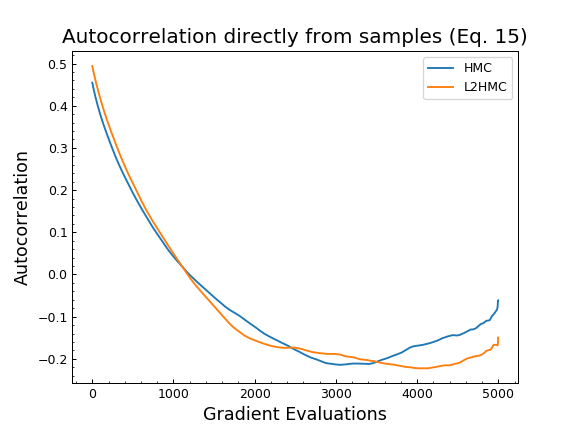

Text(0, 0.5, 'Autocorrelation')

Text(0.5, 0, 'Gradient Evaluations')

Text(0.5, 1.0, 'Autocorrelation directly from samples (Eq. 15)')

In [295]:
fig, ax = plt.subplots()
ax.plot(steps_hmc, samples_ac_spectrum_hmc, marker='', ls='-', label='HMC')
ax.plot(steps, samples_ac_spectrum, marker='', ls='-', label='L2HMC')
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.set_xlabel('Gradient Evaluations', fontsize=14)
ax.set_title("Autocorrelation directly from samples (Eq. 15)", fontsize=16)
ax.legend(loc='best')
fig.savefig(os.path.join(model_hmc.figs_dir, 'samples_autocorrelation_fn_hmc.pdf'), 
            dpi=400, bbox_inches='tight')
plt.show()

##### Compute Autocorrelation for Topological charge

In [296]:
#top_charges_acl_spectrum_hmc = compute_autocorrelation(top_charges_history_hmc, 
#                                                       top_charges_mean_hmc,
#                                                       top_charges_var_hmc)
#actions_acl_spectrum_hmc = compute_autocorrelation(actions_history_hmc, 
#                                                   actions_mean_hmc,
#                                                   actions_var_hmc)
#avg_plaquette_acl_spectrum_hmc = compute_autocorrelation(avg_plaquettes_history_hmc,
#                                                         avg_plaquettes_mean_hmc,
#                                                         avg_plaquettes_var_hmc)
#steps_hmc = np.arange(len(top_charges_acl_spectrum_hmc))

In [315]:
#top_charges_acl_spectrum_hmc = compute_autocorrelation(top_charges_history_hmc, 
#                                                       top_charges_mean_hmc,
#                                                       top_charges_var_hmc)

In [50]:
top_charges_autocorr0 = autocorr(top_charges_history[:, 0])
top_charges_autocorr1 = autocorr(top_charges_history[:, 1])

In [51]:
#top_charges_autocorr = (top_charges_autocorr0 + top_charges_autocorr1) / 2
#avg_plaquette_autocorr0 = autocorr(avg_plaquettes_history[:, 0])
#avg_plaquette_autocorr1 = autocorr(avg_plaquettes_history[:, 1])

In [ ]:
avg_plaquette_autocorr0_hmc = autocorr(avg_plaquettes_history_hmc[:, 0])
avg_plaquette_autocorr1_hmc = autocorr(avg_plaquettes_history_hmc[:, 1])

#avg_plaquette_autocorr = (avg_plaquette_autocorr0
#                          + avg_plaquette_autocorr1) / 2

avg_plaquette_autocorr_hmc = (avg_plaquette_autocorr0_hmc
                              + avg_plaquette_autocorr1_hmc) / 2

#steps = np.arange(len(avg_plaquette_autocorr))
steps_hmc = np.arange(len(avg_plaquette_autocorr_hmc))

<IPython.core.display.Javascript object>


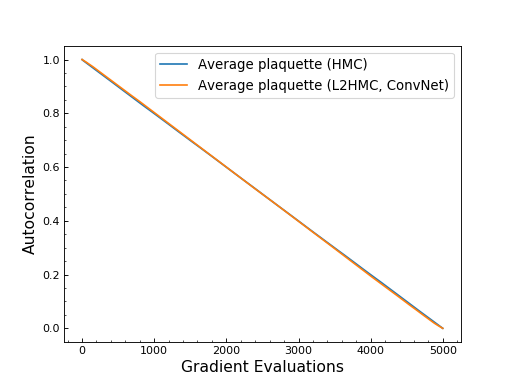

Text(0,0.5,'Autocorrelation')

Text(0.5,0,'Gradient Evaluations')

In [77]:
fig, ax = plt.subplots()
ax.plot(steps_hmc, avg_plaquette_autocorr_hmc, marker='', ls='-', label='Average plaquette (HMC)')
ax.plot(steps_conv, avg_plaquette_autocorr_conv, marker='', ls='-', label='Average plaquette (L2HMC, ConvNet)')
#ax.plot(steps, avg_plaquette_autocorr, marker='', ls='-', label='Average plaquette (L2HMC)')
#ax.plot(steps, avg_plaquette_autocorr1, marker='', ls='-', label='Average plaquette1 (L2HMC)')
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.set_xlabel('Gradient Evaluations', fontsize=14)
ax.legend(loc='best', fontsize=12)
#fig.savefig(os.path.join(model_hmc.figs_dir, 'avg_plaquette_autocorrelation_fn_hmc.pdf'), 
#            dpi=400, bbox_inches='tight')
#ax.set_xlim((-20, 450))
plt.show()

In [60]:
%matplotlib notebook

<IPython.core.display.Javascript object>


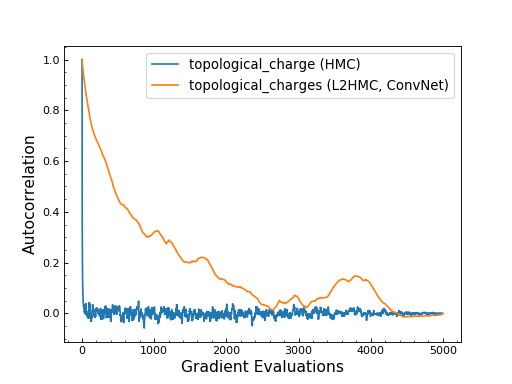

Text(0,0.5,'Autocorrelation')

Text(0.5,0,'Gradient Evaluations')

Text(0.5,1,'')

In [76]:
steps1 = np.arange(len(top_charges_autocorr0))
steps_hmc = np.arange(len(top_charges_autocorr0_hmc))
steps_conv = np.arange(len(top_charges_autocorr_conv))

fig, ax = plt.subplots()
ax.plot(steps_hmc, top_charges_autocorr_hmc, 
        marker='', ls='-', label='topological_charge (HMC)')
ax.plot(steps_conv, top_charges_autocorr_conv,
        marker='', ls='-', label='topological_charges (L2HMC, ConvNet)')
#ax.plot(steps1, top_charges_autocorr, marker='', ls='-', label='topological_charge (L2HMC)')
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.set_xlabel('Gradient Evaluations', fontsize=14)
ax.set_title("")
ax.legend(loc='best', fontsize=12)
fig.savefig(os.path.join(model_hmc.figs_dir, 
                         'top_charge_autocorrelation_fn_hmc.pdf'), 
            dpi=400, bbox_inches='tight')
#ax.set_xlim((-20, 500))
plt.show()

<IPython.core.display.Javascript object>


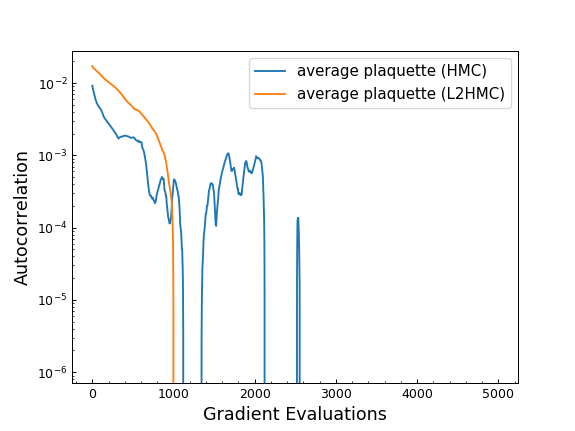

Text(0, 0.5, 'Autocorrelation')

Text(0.5, 0, 'Gradient Evaluations')

Text(0.5, 1.0, '')

In [300]:
fig, ax = plt.subplots()
#ax.semilogy(steps_hmc, actions_acl_spectrum_hmc, marker='', ls='-', label='total action (HMC)')
ax.semilogy(steps_hmc, avg_plaquette_acl_spectrum_hmc, marker='', ls='-', label='average plaquette (HMC)')
#ax.plot(steps, actions_acl_spectrum, marker='', ls='-', label='total action (L2HMC)')
ax.semilogy(steps, avg_plaquette_acl_spectrum, marker='', ls='-', label='average plaquette (L2HMC)')
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.set_xlabel('Gradient Evaluations', fontsize=14)
ax.set_title("")
ax.legend(loc='best', fontsize=12)
fig.savefig(os.path.join(model_hmc.figs_dir, 'avg_plaquette_autocorrelation_fn_hmc_semilogy.pdf'), 
            dpi=400, bbox_inches='tight')
plt.show()

#### Using L2HMC model 

In [45]:
samples = np.array(model.lattice.samples.reshape((model.batch_size, -1)), dtype=np.float32)
print(samples.shape)

(2, 128)


In [46]:
apply_transition = tfe.defun(model.dynamics.apply_transition)

In [47]:
samples = tf.random_normal(shape=model.samples.shape)
samples_history = []
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for i in range(5000):
    samples_history.append(samples.numpy())
    t0 = time.time()
    _, _, _, samples = apply_transition(samples)
    observables = np.array(model.lattice.calc_plaq_observables(samples)).T
    actions_history.append(observables[0])
    avg_plaquettes_history.append(observables[1])
    top_charges_history.append(observables[2])
    print(f'step: {i}  time/step: {time.time() - t0:^6.4g}')

step: 0  time/step: 170.8 
step: 1  time/step: 0.2495
step: 2  time/step: 0.2189
step: 3  time/step: 0.222 
step: 4  time/step: 0.2523
step: 5  time/step: 0.2314
step: 6  time/step: 0.2177
step: 7  time/step: 0.2425
step: 8  time/step: 0.2659
step: 9  time/step: 0.251 
step: 10  time/step: 0.2517
step: 11  time/step: 0.235 
step: 12  time/step: 0.2468
step: 13  time/step: 0.2282
step: 14  time/step: 0.4564
step: 15  time/step: 0.2754
step: 16  time/step: 0.2651
step: 17  time/step: 0.2196
step: 18  time/step: 0.2382
step: 19  time/step: 0.3172
step: 20  time/step: 0.244 
step: 21  time/step: 0.2084
step: 22  time/step: 0.2205
step: 23  time/step: 0.2419
step: 24  time/step: 0.265 
step: 25  time/step: 0.2497
step: 26  time/step: 0.2405
step: 27  time/step: 0.2484
step: 28  time/step: 0.2459
step: 29  time/step: 0.2331
step: 30  time/step: 0.2556
step: 31  time/step: 0.2809
step: 32  time/step: 0.2439
step: 33  time/step: 0.2301
step: 34  time/step: 0.2549
step: 35  time/step: 0.2349
st

step: 287  time/step: 0.225 
step: 288  time/step: 0.2634
step: 289  time/step: 0.2293
step: 290  time/step: 0.268 
step: 291  time/step: 0.2452
step: 292  time/step: 0.2301
step: 293  time/step: 0.2785
step: 294  time/step: 0.2247
step: 295  time/step: 0.2227
step: 296  time/step: 0.2439
step: 297  time/step: 0.3039
step: 298  time/step: 0.2566
step: 299  time/step: 0.2468
step: 300  time/step: 0.3287
step: 301  time/step: 0.3357
step: 302  time/step: 0.2935
step: 303  time/step: 0.488 
step: 304  time/step: 0.6765
step: 305  time/step: 0.4455
step: 306  time/step: 0.3157
step: 307  time/step: 0.3251
step: 308  time/step: 0.376 
step: 309  time/step: 0.2984
step: 310  time/step: 0.2872
step: 311  time/step: 0.3099
step: 312  time/step: 0.3253
step: 313  time/step: 0.2768
step: 314  time/step: 0.3371
step: 315  time/step: 0.3024
step: 316  time/step: 0.389 
step: 317  time/step: 0.3059
step: 318  time/step: 0.3606
step: 319  time/step: 0.2592
step: 320  time/step: 0.2923
step: 321  tim

step: 570  time/step: 0.4001
step: 571  time/step: 0.4231
step: 572  time/step: 0.418 
step: 573  time/step: 0.3991
step: 574  time/step: 0.4498
step: 575  time/step: 0.3935
step: 576  time/step: 0.4328
step: 577  time/step: 0.4003
step: 578  time/step: 0.4418
step: 579  time/step: 0.4601
step: 580  time/step: 0.4059
step: 581  time/step: 0.4561
step: 582  time/step: 0.4099
step: 583  time/step: 0.4288
step: 584  time/step: 0.4136
step: 585  time/step: 0.4072
step: 586  time/step: 0.4233
step: 587  time/step: 0.3956
step: 588  time/step: 0.4686
step: 589  time/step: 0.3986
step: 590  time/step: 0.4395
step: 591  time/step: 0.4149
step: 592  time/step: 0.4021
step: 593  time/step: 0.4586
step: 594  time/step: 0.3973
step: 595  time/step: 0.4458
step: 596  time/step: 0.4749
step: 597  time/step: 0.426 
step: 598  time/step: 0.4229
step: 599  time/step: 0.4009
step: 600  time/step: 0.4828
step: 601  time/step: 0.4228
step: 602  time/step: 0.4836
step: 603  time/step: 0.4026
step: 604  tim

step: 853  time/step: 0.5297
step: 854  time/step: 0.594 
step: 855  time/step: 0.494 
step: 856  time/step: 0.5548
step: 857  time/step: 0.493 
step: 858  time/step: 0.5482
step: 859  time/step: 0.5089
step: 860  time/step: 0.5554
step: 861  time/step: 0.4916
step: 862  time/step: 0.5761
step: 863  time/step: 0.5687
step: 864  time/step: 0.6063
step: 865  time/step: 0.6189
step: 866  time/step: 0.4921
step: 867  time/step: 0.5728
step: 868  time/step: 0.5485
step: 869  time/step: 0.7648
step: 870  time/step: 0.5609
step: 871  time/step: 0.4842
step: 872  time/step: 0.6375
step: 873  time/step: 0.5269
step: 874  time/step: 0.5273
step: 875  time/step: 0.5714
step: 876  time/step: 0.6424
step: 877  time/step: 0.7269
step: 878  time/step: 0.6561
step: 879  time/step: 0.6023
step: 880  time/step: 0.6547
step: 881  time/step: 0.5406
step: 882  time/step: 0.5709
step: 883  time/step: 0.5298
step: 884  time/step: 0.6195
step: 885  time/step: 0.4784
step: 886  time/step: 0.3081
step: 887  tim

step: 1131  time/step: 0.4281
step: 1132  time/step: 0.4476
step: 1133  time/step: 0.4184
step: 1134  time/step: 0.4535
step: 1135  time/step: 0.4275
step: 1136  time/step: 0.4765
step: 1137  time/step: 0.4354
step: 1138  time/step: 0.4385
step: 1139  time/step: 0.4436
step: 1140  time/step: 0.4246
step: 1141  time/step: 0.4489
step: 1142  time/step: 0.4236
step: 1143  time/step: 0.4386
step: 1144  time/step: 0.4211
step: 1145  time/step: 0.4519
step: 1146  time/step: 0.4303
step: 1147  time/step: 0.4462
step: 1148  time/step: 0.4799
step: 1149  time/step: 0.4278
step: 1150  time/step: 0.4565
step: 1151  time/step: 0.4147
step: 1152  time/step: 0.437 
step: 1153  time/step: 0.4295
step: 1154  time/step: 0.4402
step: 1155  time/step: 0.4291
step: 1156  time/step: 0.4229
step: 1157  time/step: 0.4561
step: 1158  time/step: 0.425 
step: 1159  time/step: 0.4772
step: 1160  time/step: 0.4168
step: 1161  time/step: 0.4381
step: 1162  time/step: 0.4314
step: 1163  time/step: 0.4309
step: 1164

step: 1405  time/step: 0.4346
step: 1406  time/step: 0.4403
step: 1407  time/step: 0.4402
step: 1408  time/step: 0.4357
step: 1409  time/step: 0.468 
step: 1410  time/step: 0.536 
step: 1411  time/step: 0.6219
step: 1412  time/step: 0.4474
step: 1413  time/step: 0.4893
step: 1414  time/step: 0.4531
step: 1415  time/step: 0.4577
step: 1416  time/step: 0.4404
step: 1417  time/step: 0.4706
step: 1418  time/step: 0.4389
step: 1419  time/step: 0.4755
step: 1420  time/step: 0.4377
step: 1421  time/step: 0.4709
step: 1422  time/step: 0.451 
step: 1423  time/step: 0.4631
step: 1424  time/step: 0.4827
step: 1425  time/step: 0.4455
step: 1426  time/step: 0.4668
step: 1427  time/step: 0.4229
step: 1428  time/step: 0.4673
step: 1429  time/step: 0.4275
step: 1430  time/step: 0.486 
step: 1431  time/step: 0.4397
step: 1432  time/step: 0.4585
step: 1433  time/step: 0.4509
step: 1434  time/step: 0.4582
step: 1435  time/step: 0.4929
step: 1436  time/step: 0.4353
step: 1437  time/step: 0.4577
step: 1438

step: 1679  time/step: 0.5861
step: 1680  time/step: 0.5002
step: 1681  time/step: 0.591 
step: 1682  time/step: 0.5912
step: 1683  time/step: 0.516 
step: 1684  time/step: 0.6374
step: 1685  time/step: 0.5484
step: 1686  time/step: 0.6514
step: 1687  time/step: 0.531 
step: 1688  time/step: 0.4649
step: 1689  time/step: 0.4745
step: 1690  time/step: 0.5463
step: 1691  time/step: 0.5868
step: 1692  time/step: 0.4943
step: 1693  time/step: 0.5973
step: 1694  time/step: 0.5244
step: 1695  time/step: 0.5273
step: 1696  time/step: 0.4687
step: 1697  time/step: 0.5219
step: 1698  time/step: 0.4587
step: 1699  time/step: 0.4938
step: 1700  time/step: 0.5107
step: 1701  time/step: 0.4982
step: 1702  time/step: 0.4683
step: 1703  time/step: 0.4977
step: 1704  time/step: 0.5417
step: 1705  time/step: 0.6421
step: 1706  time/step: 0.513 
step: 1707  time/step: 0.4762
step: 1708  time/step: 0.7057
step: 1709  time/step: 0.5289
step: 1710  time/step: 0.5307
step: 1711  time/step: 0.5694
step: 1712

step: 1953  time/step: 0.2701
step: 1954  time/step: 0.5473
step: 1955  time/step:  0.38 
step: 1956  time/step: 0.318 
step: 1957  time/step: 0.3295
step: 1958  time/step: 0.3344
step: 1959  time/step: 0.2909
step: 1960  time/step: 0.3252
step: 1961  time/step: 0.346 
step: 1962  time/step: 0.3173
step: 1963  time/step: 0.3282
step: 1964  time/step: 0.3036
step: 1965  time/step: 0.311 
step: 1966  time/step: 0.3331
step: 1967  time/step: 0.4268
step: 1968  time/step: 0.328 
step: 1969  time/step: 0.3102
step: 1970  time/step: 0.2996
step: 1971  time/step: 0.3023
step: 1972  time/step: 0.3225
step: 1973  time/step: 0.3205
step: 1974  time/step: 0.4473
step: 1975  time/step: 0.3928
step: 1976  time/step: 0.5838
step: 1977  time/step: 0.603 
step: 1978  time/step: 0.4793
step: 1979  time/step: 0.6177
step: 1980  time/step: 0.5739
step: 1981  time/step: 0.5516
step: 1982  time/step: 0.6081
step: 1983  time/step: 0.5486
step: 1984  time/step: 0.5417
step: 1985  time/step: 0.5982
step: 1986

step: 2227  time/step: 0.6708
step: 2228  time/step: 0.6084
step: 2229  time/step: 0.6286
step: 2230  time/step: 0.7336
step: 2231  time/step: 0.6633
step: 2232  time/step: 0.5139
step: 2233  time/step: 0.6718
step: 2234  time/step: 0.5468
step: 2235  time/step: 0.6461
step: 2236  time/step: 0.4876
step: 2237  time/step: 0.5447
step: 2238  time/step: 0.6065
step: 2239  time/step: 0.678 
step: 2240  time/step: 0.5105
step: 2241  time/step: 0.4852
step: 2242  time/step: 0.6248
step: 2243  time/step: 0.5626
step: 2244  time/step: 0.5413
step: 2245  time/step: 0.5914
step: 2246  time/step: 0.5118
step: 2247  time/step: 0.6585
step: 2248  time/step: 0.5714
step: 2249  time/step: 0.5957
step: 2250  time/step: 0.5217
step: 2251  time/step: 0.5891
step: 2252  time/step: 0.6379
step: 2253  time/step: 0.4935
step: 2254  time/step: 0.6368
step: 2255  time/step: 0.5092
step: 2256  time/step: 0.8803
step: 2257  time/step: 0.6403
step: 2258  time/step: 0.5208
step: 2259  time/step: 0.5764
step: 2260

step: 2501  time/step: 0.5543
step: 2502  time/step: 0.5736
step: 2503  time/step: 0.6187
step: 2504  time/step: 0.6332
step: 2505  time/step: 0.5814
step: 2506  time/step: 0.5485
step: 2507  time/step: 0.799 
step: 2508  time/step: 0.6462
step: 2509  time/step:  0.56 
step: 2510  time/step: 0.6013
step: 2511  time/step: 0.5337
step: 2512  time/step: 0.5882
step: 2513  time/step: 0.5723
step: 2514  time/step: 0.5708
step: 2515  time/step: 0.9397
step: 2516  time/step: 0.6995
step: 2517  time/step: 0.5042
step: 2518  time/step: 0.6108
step: 2519  time/step: 0.5952
step: 2520  time/step: 0.6392
step: 2521  time/step: 0.6275
step: 2522  time/step: 0.5599
step: 2523  time/step: 0.5494
step: 2524  time/step: 0.6894
step: 2525  time/step: 0.5866
step: 2526  time/step: 0.6332
step: 2527  time/step: 0.5699
step: 2528  time/step: 0.5265
step: 2529  time/step: 0.5957
step: 2530  time/step: 0.5311
step: 2531  time/step: 0.6368
step: 2532  time/step: 0.5647
step: 2533  time/step: 0.546 
step: 2534

step: 2775  time/step: 0.6157
step: 2776  time/step: 0.573 
step: 2777  time/step: 0.5892
step: 2778  time/step: 0.691 
step: 2779  time/step: 0.558 
step: 2780  time/step: 0.5764
step: 2781  time/step: 0.6248
step: 2782  time/step: 0.5291
step: 2783  time/step: 0.6279
step: 2784  time/step: 0.5121
step: 2785  time/step: 0.4993
step: 2786  time/step: 0.5161
step: 2787  time/step: 0.5903
step: 2788  time/step: 0.4856
step: 2789  time/step: 0.5246
step: 2790  time/step: 0.6326
step: 2791  time/step: 0.5896
step: 2792  time/step: 0.5444
step: 2793  time/step: 0.5326
step: 2794  time/step: 0.5482
step: 2795  time/step: 0.5251
step: 2796  time/step: 0.5897
step: 2797  time/step: 0.5978
step: 2798  time/step: 0.5854
step: 2799  time/step: 0.612 
step: 2800  time/step: 0.5574
step: 2801  time/step: 0.5834
step: 2802  time/step: 0.5776
step: 2803  time/step: 0.5355
step: 2804  time/step: 0.4884
step: 2805  time/step: 0.5596
step: 2806  time/step: 0.5693
step: 2807  time/step: 0.5419
step: 2808

step: 3049  time/step: 0.5107
step: 3050  time/step: 0.5101
step: 3051  time/step: 0.526 
step: 3052  time/step: 0.4616
step: 3053  time/step: 0.5366
step: 3054  time/step: 0.468 
step: 3055  time/step: 0.5309
step: 3056  time/step: 0.4892
step: 3057  time/step: 0.5524
step: 3058  time/step: 0.714 
step: 3059  time/step: 0.5246
step: 3060  time/step: 0.6319
step: 3061  time/step: 0.5266
step: 3062  time/step: 0.6508
step: 3063  time/step: 0.5094
step: 3064  time/step: 0.5898
step: 3065  time/step: 0.5656
step: 3066  time/step: 0.5824
step: 3067  time/step: 0.5287
step: 3068  time/step: 0.4471
step: 3069  time/step: 0.5337
step: 3070  time/step: 0.443 
step: 3071  time/step: 0.4983
step: 3072  time/step: 0.6528
step: 3073  time/step: 0.5733
step: 3074  time/step: 0.4923
step: 3075  time/step: 0.5903
step: 3076  time/step: 0.5216
step: 3077  time/step: 0.5955
step: 3078  time/step: 0.587 
step: 3079  time/step: 0.4969
step: 3080  time/step: 0.5616
step: 3081  time/step: 0.4644
step: 3082

step: 3323  time/step: 0.5401
step: 3324  time/step: 0.4733
step: 3325  time/step: 0.6243
step: 3326  time/step: 0.5337
step: 3327  time/step: 0.5097
step: 3328  time/step: 0.4753
step: 3329  time/step: 0.5543
step: 3330  time/step: 0.6337
step: 3331  time/step: 0.5595
step: 3332  time/step: 0.5704
step: 3333  time/step: 0.4811
step: 3334  time/step: 0.5934
step: 3335  time/step: 0.6303
step: 3336  time/step: 0.8761
step: 3337  time/step: 0.5985
step: 3338  time/step: 0.6436
step: 3339  time/step: 0.7249
step: 3340  time/step: 0.6342
step: 3341  time/step: 0.5053
step: 3342  time/step: 0.545 
step: 3343  time/step: 0.5839
step: 3344  time/step: 0.5569
step: 3345  time/step: 0.5958
step: 3346  time/step: 0.5092
step: 3347  time/step: 0.5298
step: 3348  time/step: 0.6714
step: 3349  time/step: 0.4892
step: 3350  time/step: 0.5822
step: 3351  time/step: 0.5449
step: 3352  time/step: 0.6371
step: 3353  time/step: 0.5677
step: 3354  time/step: 0.6197
step: 3355  time/step: 0.5544
step: 3356

step: 3597  time/step: 0.4485
step: 3598  time/step:  0.47 
step: 3599  time/step: 0.4748
step: 3600  time/step: 0.4691
step: 3601  time/step: 0.4587
step: 3602  time/step: 0.4585
step: 3603  time/step: 0.4618
step: 3604  time/step: 0.4525
step: 3605  time/step: 0.4764
step: 3606  time/step: 0.4437
step: 3607  time/step: 0.5189
step: 3608  time/step: 0.4632
step: 3609  time/step: 0.5203
step: 3610  time/step: 0.4826
step: 3611  time/step: 0.5605
step: 3612  time/step: 0.4926
step: 3613  time/step: 0.5334
step: 3614  time/step: 0.4845
step: 3615  time/step: 0.5391
step: 3616  time/step: 0.4715
step: 3617  time/step: 0.578 
step: 3618  time/step: 0.4504
step: 3619  time/step: 0.5118
step: 3620  time/step: 0.4359
step: 3621  time/step: 0.5616
step: 3622  time/step: 0.5535
step: 3623  time/step: 0.5007
step: 3624  time/step: 0.5627
step: 3625  time/step: 0.5577
step: 3626  time/step: 0.6363
step: 3627  time/step: 0.4557
step: 3628  time/step: 0.4349
step: 3629  time/step: 0.5304
step: 3630

step: 3871  time/step: 0.7192
step: 3872  time/step: 0.6921
step: 3873  time/step: 0.4788
step: 3874  time/step: 0.4688
step: 3875  time/step: 0.5031
step: 3876  time/step: 0.5037
step: 3877  time/step: 0.6243
step: 3878  time/step: 0.5987
step: 3879  time/step: 0.5806
step: 3880  time/step: 0.5582
step: 3881  time/step: 0.5929
step: 3882  time/step: 0.5251
step: 3883  time/step: 0.5266
step: 3884  time/step: 0.5795
step: 3885  time/step: 0.704 
step: 3886  time/step: 0.586 
step: 3887  time/step: 0.5967
step: 3888  time/step: 0.5751
step: 3889  time/step: 0.5484
step: 3890  time/step: 0.4627
step: 3891  time/step: 0.6578
step: 3892  time/step: 0.5806
step: 3893  time/step: 0.5337
step: 3894  time/step: 0.6309
step: 3895  time/step: 0.5708
step: 3896  time/step: 0.5843
step: 3897  time/step: 0.6282
step: 3898  time/step: 0.5342
step: 3899  time/step: 0.6214
step: 3900  time/step: 0.6023
step: 3901  time/step: 0.6109
step: 3902  time/step: 0.673 
step: 3903  time/step: 0.5262
step: 3904

step: 4145  time/step: 0.2953
step: 4146  time/step: 0.3385
step: 4147  time/step: 0.2884
step: 4148  time/step: 0.285 
step: 4149  time/step: 0.301 
step: 4150  time/step: 0.2857
step: 4151  time/step: 0.2893
step: 4152  time/step: 0.3015
step: 4153  time/step: 0.3021
step: 4154  time/step: 0.2703
step: 4155  time/step: 0.2959
step: 4156  time/step: 0.3034
step: 4157  time/step: 0.2946
step: 4158  time/step: 0.2652
step: 4159  time/step: 0.266 
step: 4160  time/step: 0.3019
step: 4161  time/step: 0.2553
step: 4162  time/step: 0.2491
step: 4163  time/step: 0.2921
step: 4164  time/step: 0.2534
step: 4165  time/step: 0.2448
step: 4166  time/step: 0.2438
step: 4167  time/step: 0.2524
step: 4168  time/step: 0.2511
step: 4169  time/step: 0.2475
step: 4170  time/step: 0.2644
step: 4171  time/step: 0.2641
step: 4172  time/step: 0.2557
step: 4173  time/step: 0.2553
step: 4174  time/step: 0.252 
step: 4175  time/step: 0.2599
step: 4176  time/step: 0.2774
step: 4177  time/step: 0.3006
step: 4178

step: 4419  time/step: 0.2744
step: 4420  time/step: 0.339 
step: 4421  time/step: 0.3632
step: 4422  time/step: 0.3523
step: 4423  time/step: 0.3333
step: 4424  time/step: 0.3378
step: 4425  time/step: 0.3023
step: 4426  time/step: 0.346 
step: 4427  time/step: 0.2947
step: 4428  time/step: 0.3648
step: 4429  time/step: 0.4321
step: 4430  time/step: 0.3684
step: 4431  time/step: 0.3283
step: 4432  time/step: 0.3326
step: 4433  time/step: 0.3116
step: 4434  time/step: 0.3132
step: 4435  time/step: 0.3492
step: 4436  time/step: 0.3179
step: 4437  time/step: 0.2946
step: 4438  time/step: 0.2929
step: 4439  time/step: 0.318 
step: 4440  time/step: 0.2771
step: 4441  time/step: 0.3005
step: 4442  time/step: 0.3246
step: 4443  time/step: 0.2955
step: 4444  time/step: 0.2982
step: 4445  time/step: 0.3037
step: 4446  time/step: 0.3286
step: 4447  time/step: 0.2779
step: 4448  time/step: 0.319 
step: 4449  time/step: 0.2736
step: 4450  time/step: 0.2811
step: 4451  time/step: 0.3127
step: 4452

step: 4693  time/step: 0.3121
step: 4694  time/step: 0.3295
step: 4695  time/step: 0.3103
step: 4696  time/step: 0.3233
step: 4697  time/step: 0.3616
step: 4698  time/step: 0.3078
step: 4699  time/step: 0.2597
step: 4700  time/step: 0.2903
step: 4701  time/step: 0.3158
step: 4702  time/step: 0.2876
step: 4703  time/step: 0.3556
step: 4704  time/step: 0.3569
step: 4705  time/step: 0.305 
step: 4706  time/step: 0.2898
step: 4707  time/step: 0.3523
step: 4708  time/step: 0.3123
step: 4709  time/step: 0.323 
step: 4710  time/step: 0.3936
step: 4711  time/step: 0.2827
step: 4712  time/step: 0.3174
step: 4713  time/step: 0.3387
step: 4714  time/step: 0.3183
step: 4715  time/step: 0.3959
step: 4716  time/step: 0.3622
step: 4717  time/step: 0.301 
step: 4718  time/step: 0.3146
step: 4719  time/step: 0.2866
step: 4720  time/step: 0.3683
step: 4721  time/step: 0.3296
step: 4722  time/step: 0.3104
step: 4723  time/step: 0.3034
step: 4724  time/step:  0.32 
step: 4725  time/step: 0.3938
step: 4726

step: 4967  time/step: 0.2639
step: 4968  time/step: 0.2976
step: 4969  time/step: 0.3049
step: 4970  time/step: 0.3123
step: 4971  time/step: 0.3087
step: 4972  time/step: 0.2626
step: 4973  time/step: 0.3008
step: 4974  time/step: 0.3367
step: 4975  time/step: 0.3067
step: 4976  time/step: 0.3064
step: 4977  time/step: 0.286 
step: 4978  time/step: 0.3035
step: 4979  time/step: 0.2968
step: 4980  time/step: 0.3137
step: 4981  time/step: 0.3198
step: 4982  time/step: 0.3082
step: 4983  time/step: 0.3081
step: 4984  time/step: 0.3209
step: 4985  time/step: 0.3067
step: 4986  time/step: 0.3154
step: 4987  time/step: 0.3204
step: 4988  time/step: 0.2911
step: 4989  time/step: 0.2816
step: 4990  time/step: 0.3312
step: 4991  time/step: 0.2849
step: 4992  time/step: 0.2805
step: 4993  time/step: 0.2918
step: 4994  time/step: 0.3015
step: 4995  time/step: 0.2849
step: 4996  time/step: 0.2627
step: 4997  time/step: 0.3004
step: 4998  time/step: 0.3352
step: 4999  time/step: 0.2541


In [49]:
samples_history = np.array(samples_history)
actions_history = np.array(actions_history)
avg_plaquettes_history = np.array(avg_plaquettes_history)
top_charges_history = np.array(top_charges_history)

In [75]:
top_charges_autocorr0_conv = autocorr(top_charges_history_conv[:, 0])
top_charges_autocorr1_conv = autocorr(top_charges_history_conv[:, 1])
avg_plaquette_autocorr0_conv = autocorr(avg_plaquettes_history_conv[:, 0])
avg_plaquette_autocorr1_conv = autocorr(avg_plaquettes_history_conv[:, 1])

top_charges_autocorr_conv = (top_charges_autocorr0_conv 
                             + top_charges_autocorr1_conv) / 2
avg_plaquette_autocorr_conv = (avg_plaquette_autocorr0_conv
                               + avg_plaquette_autocorr1_conv) / 2

##### Compute Autocorrelation spectrum directly from samples

In [291]:
samples_ac_spectrum = compute_ac_spectrum(samples_history, 
                                          samples_history_mean,
                                          samples_history_var)

#ax.plot(steps, samples_ac_spectrum, marker='', ls='-', label='L2HMC')
steps = np.arange(len(samples_ac_spectrum))

In [250]:
%matplotlib notebook

<IPython.core.display.Javascript object>


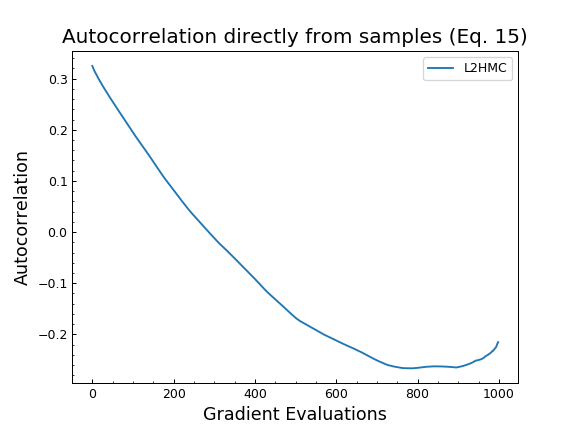

Text(0, 0.5, 'Autocorrelation')

Text(0.5, 0, 'Gradient Evaluations')

Text(0.5, 1.0, 'Autocorrelation directly from samples (Eq. 15)')

In [252]:
fig, ax = plt.subplots()
ax.plot(steps, samples_ac_spectrum, marker='', ls='-', label='L2HMC')
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.set_xlabel('Gradient Evaluations', fontsize=14)
ax.set_title("Autocorrelation directly from samples (Eq. 15)", fontsize=16)
ax.legend(loc='best')
fig.savefig(os.path.join(model.figs_dir, 'samples_autocorrelation_fn.pdf'), 
            dpi=400, bbox_inches='tight')
plt.show()

##### Compute Autocorrelation for Topological charge

In [292]:
top_charges_acl_spectrum = compute_autocorrelation(top_charges_history, 
                                                   top_charges_mean,
                                                   top_charges_var)
actions_acl_spectrum = compute_autocorrelation(actions_history, 
                                               actions_mean,
                                               actions_var)
avg_plaquette_acl_spectrum = compute_autocorrelation(avg_plaquettes_history,
                                                     avg_plaquettes_mean,
                                                     avg_plaquettes_var)
steps = np.arange(len(top_charges_acl_spectrum))

<IPython.core.display.Javascript object>


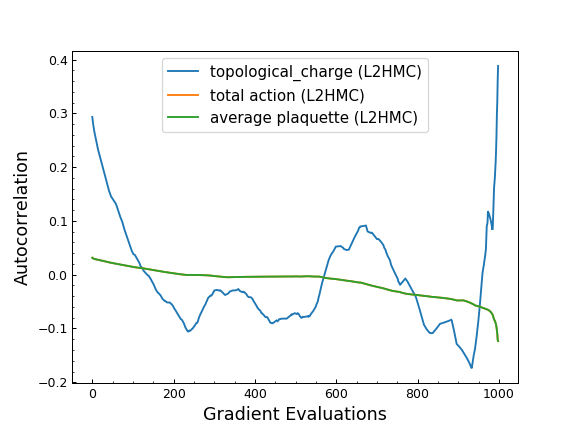

Text(0, 0.5, 'Autocorrelation')

Text(0.5, 0, 'Gradient Evaluations')

Text(0.5, 1.0, '')

In [253]:
fig, ax = plt.subplots()
ax.plot(steps, top_charges_acl_spectrum, marker='', ls='-', label='topological_charge (L2HMC)')
ax.plot(steps, actions_acl_spectrum, marker='', ls='-', label='total action (L2HMC)')
ax.plot(steps, avg_plaquette_acl_spectrum, marker='', ls='-', label='average plaquette (L2HMC)')
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.set_xlabel('Gradient Evaluations', fontsize=14)
ax.set_title("")
ax.legend(loc='best', fontsize=12)
fig.savefig(os.path.join(model.figs_dir, 'observables_autocorrelation_fn.pdf'), 
            dpi=400, bbox_inches='tight')
plt.show()

In [305]:
samples_ac_spectrum_file = os.path.join(model.info_dir,
                                        'samples_ac_spectrum.pkl')
top_charges_acl_spectrum_file = os.path.join(model.info_dir,
                                             'top_charges_acl_spectrum.pkl')
actions_acl_spectrum_file = os.path.join(model.info_dir,
                                         'actions_acl_spectrum.pkl')
avg_plaquette_acl_spectrum_file = os.path.join(model.info_dir,
                                               'avg_plaquette_acl_spectrum.pkl')
with open(samples_ac_spectrum_file, 'wb') as f:
    pickle.dump(samples_ac_spectrum, f)

with open(top_charges_acl_spectrum_file, 'wb') as f:
    pickle.dump(top_charges_acl_spectrum, f)
    
with open(actions_acl_spectrum_file, 'wb') as f:
    pickle.dump(actions_acl_spectrum, f)
    
with open(avg_plaquette_acl_spectrum_file, 'wb') as f:
    pickle.dump(avg_plaquette_acl_spectrum, f)

### Load / Restore from previous run

In [92]:
model_l2hmc = GaugeModelEager(params=params, log_dir='../../gauge_logs_eager/run_40/', restore=True, use_defun=True)

Creating lattice...
done.
Creating dynamics...
done.
Restored latest checkpoint from:"/Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_40/ckpt-10"
total initialization time: 0.3111836910247803

################################################################################
Model parameters:
_defun: True

conv_net: True

time_size: 8

space_size: 8

link_type: U1

dim: 2

beta: 3.5

num_samples: 2

n_steps: 5

eps: 0.1

loss_scale: 0.1

loss_eps: 0.0001

learning_rate_init: 0.0001

learning_rate_decay_steps: 100

learning_rate_decay_rate: 0.96

train_steps: 1000

record_loss_every: 50

data_steps: 10

save_steps: 50

print_steps: 1

logging_steps: 5

clip_value: 100

rand: False

metric: l2

hmc: True

log_dir: ../../gauge_logs_eager/run_40/

info_dir: ../../gauge_logs_eager/run_40/run_info/

figs_dir: ../../gauge_logs_eager/run_40/figures/

batch_size: 2

################################################################################




In [94]:
avg_plaq_arr_hmc = model.data['average_plaquettes_arr']
top_charge_arr_hmc = model.data['topological_charges_arr']
total_actions_arr_hmc = model.data['total_actions_arr']
steps = np.arange(500)

In [97]:
avg_plaq_arr_hmc.shape

(500, 2)

In [98]:
avg_plaq_arr_l2hmc

array([], dtype=float64)

In [14]:
steps = np.arange(500)

#### Compare plots across runs

Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_51/figures/average_plaquettes_vs_step.pdf...
Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_51/figures/average_topological_charge_vs_step.pdf...
Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_51/figures/average_total_action_vs_step.pdf...
done.


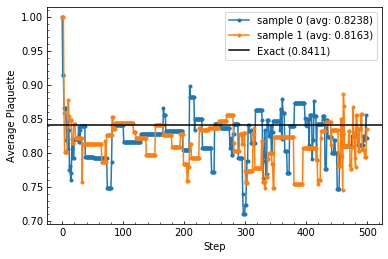

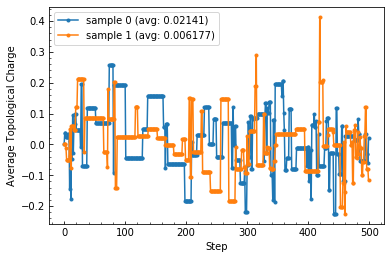

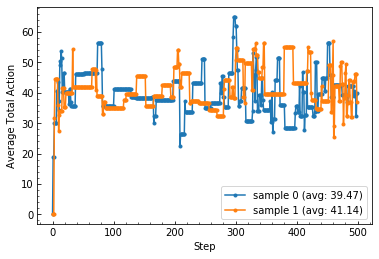

In [15]:
plot_run_data(model.data, model.params, steps, model.figs_dir, skip_steps=1)

In [100]:
average_plaquettes_file_l2hmc = os.path.join(model_l2hmc.info_dir,
                                             'average_plaquettes.npy')
top_charge_file_l2hmc = os.path.join(model_l2hmc.info_dir,
                                     'topological_charges.npy')
total_actions_file_l2hmc = os.path.join(model_l2hmc.info_dir,
                                        'total_actions.npy')
avg_plaq_arr_l2hmc = np.load(average_plaquettes_file_l2hmc)
top_charge_arr_l2hmc = np.load(top_charge_file_l2hmc)
total_actions_arr_l2hmc = np.load(total_actions_file_l2hmc)

In [107]:
model_l2hmc.topological_charges_arr = []
model_l2hmc.average_plaquettes_arr = []
model_l2hmc.total_actions_arr = []

In [108]:
model_l2hmc._update_data(total_actions_arr_l2hmc,
                         avg_plaq_arr_l2hmc,
                         top_charge_arr_l2hmc)

<IPython.core.display.Javascript object>


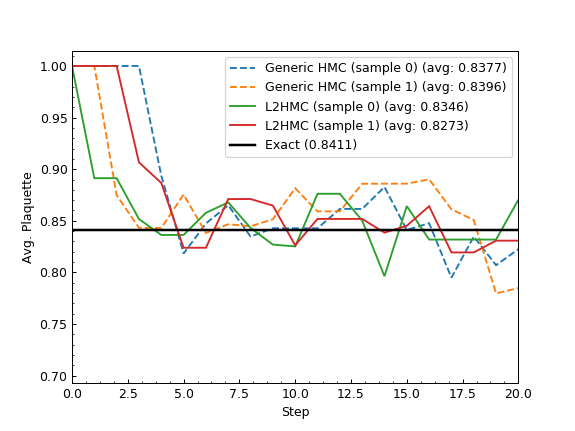

Text(0, 0.5, 'Avg. Plaquette')

Text(0.5, 0, 'Step')

(0, 20)

In [120]:
fig, ax = plt.subplots()
ax.plot(steps, avg_plaq_arr_hmc[:, 0], marker='', markersize=4., ls='--', label=f'Generic HMC (sample 0) (avg: {np.mean(avg_plaq_arr_hmc[:, 0]):^5.4g})')
ax.plot(steps, avg_plaq_arr_hmc[:, 1], marker='', markersize=4., ls='--', label=f'Generic HMC (sample 1) (avg: {np.mean(avg_plaq_arr_hmc[:, 1]):^5.4g})')
ax.plot(steps, avg_plaq_arr_l2hmc[:, 0], marker='', markersize=4., ls='-', label=f'L2HMC (sample 0) (avg: {np.mean(avg_plaq_arr_l2hmc[:, 0]):^5.4g})')
ax.plot(steps, avg_plaq_arr_l2hmc[:, 1], marker='', markersize=4., ls='-', label=f'L2HMC (sample 1) (avg: {np.mean(avg_plaq_arr_l2hmc[:, 1]):^5.4g})')
#ax.plot(steps, avg_plaq_arr_l2hmc[:, 0], marker='.', ls='-', label=f'L2HMC (avg: {np.mean(avg_plaq_arr[:, 1]):^5.4g})')
#ax.axhline(np.mean(avg_plaq_arr[:,0]), xmin=0, xmax=500, color='C0', ls='-', lw=2., label='Sample 1 (avg)')
#ax.axhline(np.mean(avg_plaq_arr[:,1]), xmin=0, xmax=500, color='C1', ls='-', lw=2., label='Sample 2 (avg)')
ax.axhline(u1_plaq_exact(params['beta']), xmin=0, xmax=500, color='k', lw=2., label=f"Exact ({u1_plaq_exact(params['beta']):^5.4g})")
ax.set_ylabel('Avg. Plaquette')
ax.set_xlabel('Step')
ax.set_xlim((0, 20))
ax.legend(loc='best')
#file_name = os.path.join(model.figs_dir, 'average_plaquettes.pdf')
#fig.savefig(file_name, dpi=400, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


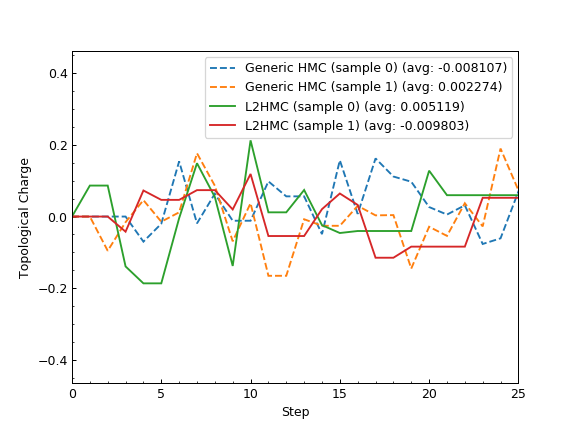

In [125]:
fig, ax = plt.subplots()
#ax.plot(steps[::5], top_charge_arr[:, 0][::5], marker='.', ls='-', label='sample 1')
#ax.plot(steps[::5], top_charge_arr[:, 1][::5], marker='.', ls='-', label='sample 2')
_ = ax.plot(steps, top_charge_arr_hmc[:, 0], marker='', markersize=4., ls='--', label=f'Generic HMC (sample 0) (avg: {np.mean(top_charge_arr_hmc[:, 0]):^5.4g})')
_ = ax.plot(steps, top_charge_arr_hmc[:, 1], marker='', markersize=4., ls='--', label=f'Generic HMC (sample 1) (avg: {np.mean(top_charge_arr_hmc[:, 1]):^5.4g})')
_ = ax.plot(steps, top_charge_arr_l2hmc[:, 0], marker='', markersize=4., ls='-', label=f'L2HMC (sample 0) (avg: {np.mean(top_charge_arr_l2hmc[:, 0]):^5.4g})')
_ = ax.plot(steps, top_charge_arr_l2hmc[:, 1], marker='', markersize=4., ls='-', label=f'L2HMC (sample 1) (avg: {np.mean(top_charge_arr_l2hmc[:, 1]):^5.4g})')
#ax.axhline(u1_plaq_exact(params['beta']), xmin=0, xmax=500, color='r', label='Exact')
_ = ax.set_ylabel('Topological Charge')
_ = ax.set_xlabel('Step')
_ = ax.legend(loc='best')
_ = ax.set_xlim((0, 25))
_ = plt.show()

<IPython.core.display.Javascript object>


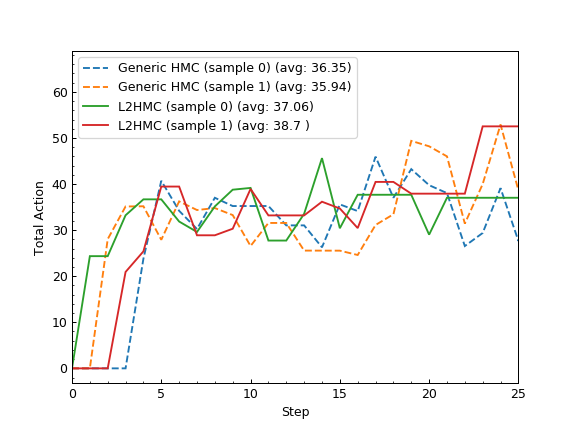

In [126]:
fig, ax = plt.subplots()
#ax.plot(steps[::5], total_action_arr[:, 0][::5], marker='.', ls='-', label='sample 1')
#ax.plot(steps[::5], total_action_arr[:, 1][::5], marker='.', ls='-', label='sample 2')
_ = ax.plot(steps, total_action_arr_hmc[:, 0], marker='', markersize=4., ls='--', label=f'Generic HMC (sample 0) (avg: {np.mean(total_action_arr_hmc[:, 0]):^5.4g})')
_ = ax.plot(steps, total_action_arr_hmc[:, 1], marker='', markersize=4., ls='--', label=f'Generic HMC (sample 1) (avg: {np.mean(total_action_arr_hmc[:, 1]):^5.4g})')
_ = ax.plot(steps, total_actions_arr_l2hmc[:, 0], marker='', markersize=4., ls='-', label=f'L2HMC (sample 0) (avg: {np.mean(total_actions_arr_l2hmc[:, 0]):^5.4g})')
_ = ax.plot(steps, total_actions_arr_l2hmc[:, 1], marker='', markersize=4., ls='-', label=f'L2HMC (sample 1) (avg: {np.mean(total_actions_arr_l2hmc[:, 1]):^5.4g})')
#ax.axhline(u1_plaq_exact(params['beta']), xmin=0, xmax=500, color='r', label='Exact')
_ = ax.set_ylabel('Total Action')
_ = ax.set_xlabel('Step')
_ = ax.legend(loc='best')
_ = ax.set_xlim((0, 25))
_ = plt.show()

In [55]:
avg_plaq1_mean, avg_plaq1_err = calc_avg_vals_errors(avg_plaq_arr[100:, 0], num_blocks=100)
avg_plaq2_mean, avg_plaq2_err = calc_avg_vals_errors(avg_plaq_arr[100:, 1], num_blocks=100)
print(avg_plaq1_mean, avg_plaq1_err)
print(avg_plaq2_mean, avg_plaq2_err)

0.8356968 0.002248044943648669
0.82549673 0.0023434074351493988


In [52]:
u1_plaq_exact(params['beta'])

0.8411037970508364

In [ ]:
model.

In [21]:
print(model.learning_rate.eval())

AttributeError: 'function' object has no attribute 'eval'

In [16]:
model.data['avg_top_charge']

-0.0009848753

In [25]:
avg_plaqs = np.array(model.average_plaquettes_arr)

In [26]:
avg_plaqs.mean()

0.8268357

In [20]:
u1_plaq_exact(params['beta'])

0.8411037970508364

## Iterate over different `eps` and `n_steps`

In [ ]:
eps_arr = np.linspace(0.02, 0.2, 10)
n_steps_arr = [5, 10, 15]

for eps in eps_arr:
    for n_steps in n_steps_arr:
        params['eps'] = eps
        params['n_steps'] = n_steps
        
        tf.reset_default_graph()
        model = GaugeModelEager(params=params,
                                log_dir=None,
                                restore=False,
                                use_defun=True)
        _ = model.calc_observables(model.samples, _print=True, _write=True)
        model.train(1)
        
        model.train(1000)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_33/
Creating lattice...
done.
Creating dynamics...
done.
total initialization time: 0.45976877212524414



step: 0   loss:   0     time/step:   0     accept:   0     eps:  0.02   avg_action:   0     avg_top_charge:   0     avg_plaq:   1    

Training complete.
Saved checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_33/ckpt-1
avg_plaquettes: [1. 1.]



step: 1   loss: -46067  time/step: 2298.5  accept:   1     eps: 0.0199  avg_action: 4.5088  avg_top_charge: -0.0084214  avg_plaq: 0.97987 



step: 2   loss: -39887  time/step: 2.6233  accept: 0.87584  eps: 0.019803  avg_action: 7.9382  avg_top_charge: 0.027706  avg_plaq: 0.96456 



step: 3   loss: -32425  time/step: 0.96702  accept:   1     eps: 0.019708  avg_action: 11.23   avg_top_charge: -0.015638  avg_plaq: 0.94987 



step: 4   loss: -35301  time/step: 1.0456  accept:   1     eps: 0.019627  avg_action: 13.554  avg_top_charge: -0.016802  avg_p



step: 55  loss: -24023  time/step: 1.302   accept:   1     eps: 0.015494  avg_action: 36.842  avg_top_charge: -0.042312  avg_plaq: 0.83553 



step: 56  loss: -27879  time/step: 1.2153  accept:   1     eps: 0.015428  avg_action: 37.481  avg_top_charge: -0.032778  avg_plaq: 0.83268 



step: 57  loss: -26094  time/step: 0.99308  accept:   1     eps: 0.015356  avg_action: 38.483  avg_top_charge: -0.031761  avg_plaq: 0.8282 



step: 58  loss: -24872  time/step: 1.1159  accept: 0.90239  eps: 0.015286  avg_action: 39.298  avg_top_charge: -0.046181  avg_plaq: 0.82456 



step: 59  loss: -20923  time/step: 1.0442  accept: 0.77648  eps: 0.015208  avg_action: 40.192  avg_top_charge: -0.045251  avg_plaq: 0.82057 



step: 60  loss: -24250  time/step: 1.122   accept: 0.87154  eps: 0.015135  avg_action: 40.58   avg_top_charge: -0.050191  avg_plaq: 0.81884 



step: 61  loss: -25761  time/step: 1.0684  accept: 0.73025  eps: 0.015061  avg_action: 40.939  avg_top_charge: -0.032449  avg_plaq: 0.817



step: 112 loss: -25207  time/step: 1.1162  accept:   1     eps: 0.011078  avg_action: 37.388  avg_top_charge: -0.079904  avg_plaq: 0.83309 



step: 113 loss: -27428  time/step: 1.1816  accept:   1     eps: 0.011   avg_action: 39.066  avg_top_charge: -0.078611  avg_plaq: 0.8256 



step: 114 loss: -25815  time/step: 1.4721  accept:   1     eps: 0.010926  avg_action: 38.678  avg_top_charge: -0.080663  avg_plaq: 0.82733 



step: 115 loss: -27327  time/step: 1.0206  accept:   1     eps: 0.010855  avg_action: 37.544  avg_top_charge: -0.075244  avg_plaq: 0.83239 



step: 116 loss: -26501  time/step: 1.1093  accept:   1     eps: 0.010781  avg_action: 40.117  avg_top_charge: -0.059843  avg_plaq: 0.82091 



step: 117 loss: -23620  time/step: 1.068   accept:   1     eps: 0.010696  avg_action: 39.007  avg_top_charge: -0.062842  avg_plaq: 0.82586 



step: 118 loss: -26413  time/step: 1.3635  accept:   1     eps: 0.010617  avg_action: 40.108  avg_top_charge: -0.05164  avg_plaq: 0.82095 



s



step: 169 loss: -23527  time/step: 1.1027  accept: 0.97562  eps: 0.0072209  avg_action: 44.79   avg_top_charge: -0.067086  avg_plaq: 0.80004 



step: 170 loss: -20810  time/step: 1.0461  accept: 0.94465  eps: 0.0071331  avg_action: 45.026  avg_top_charge: -0.054695  avg_plaq: 0.79899 



step: 171 loss: -26758  time/step: 1.1045  accept: 0.96048  eps: 0.0070473  avg_action: 46.56   avg_top_charge: -0.05476  avg_plaq: 0.79214 



step: 172 loss: -25292  time/step: 1.0062  accept:   1     eps: 0.0069623  avg_action: 47.448  avg_top_charge: -0.059711  avg_plaq: 0.78818 



step: 173 loss: -24677  time/step: 1.0699  accept: 0.92931  eps: 0.0068838  avg_action: 47.032  avg_top_charge: -0.055745  avg_plaq: 0.79003 



step: 174 loss: -20865  time/step: 1.1371  accept:   1     eps: 0.0067868  avg_action: 46.295  avg_top_charge: -0.055594  avg_plaq: 0.79332 



step: 175 loss: -25921  time/step: 1.3797  accept:   1     eps: 0.0066958  avg_action: 47.154  avg_top_charge: -0.06522  avg_plaq: 



step: 226 loss: -25629  time/step: 1.0793  accept:   1     eps: 0.0027688  avg_action: 53.95   avg_top_charge: -0.10768  avg_plaq: 0.75915 



step: 227 loss: -25583  time/step: 1.083   accept:   1     eps: 0.0027114  avg_action: 53.87   avg_top_charge: -0.10153  avg_plaq: 0.75951 



step: 228 loss: -24863  time/step: 1.0955  accept: 0.99293  eps: 0.0026595  avg_action: 54.03   avg_top_charge: -0.10188  avg_plaq: 0.7588 



step: 229 loss: -22832  time/step:  1.13   accept:   1     eps: 0.0026076  avg_action: 53.711  avg_top_charge: -0.1018  avg_plaq: 0.76022 



step: 230 loss: -25458  time/step: 1.1183  accept:   1     eps: 0.0025493  avg_action: 54.468  avg_top_charge: -0.099276  avg_plaq: 0.75684 



step: 231 loss: -25055  time/step: 1.0853  accept:   1     eps: 0.0024927  avg_action: 54.546  avg_top_charge: -0.098309  avg_plaq: 0.75649 



step: 232 loss: -24211  time/step: 1.0943  accept:   1     eps: 0.0024285  avg_action: 54.561  avg_top_charge: -0.095543  avg_plaq: 0.75643



step: 282 loss: -27510  time/step: 1.1106  accept: 0.99764  eps: 0.00093749  avg_action: 54.411  avg_top_charge: -0.10015  avg_plaq: 0.7571 



step: 283 loss: -23273  time/step: 1.1033  accept:   1     eps: 0.00096267  avg_action: 54.458  avg_top_charge: -0.099426  avg_plaq: 0.75689 



step: 284 loss: -26423  time/step: 1.1624  accept:   1     eps: 0.00098649  avg_action: 54.392  avg_top_charge: -0.10087  avg_plaq: 0.75718 



step: 285 loss: -25012  time/step: 1.1269  accept: 0.99719  eps: 0.0010008  avg_action: 54.451  avg_top_charge: -0.10104  avg_plaq: 0.75691 



step: 286 loss: -24494  time/step: 1.052   accept:   1     eps: 0.0010068  avg_action: 54.423  avg_top_charge: -0.10077  avg_plaq: 0.75704 



step: 287 loss: -25252  time/step: 1.066   accept: 0.99498  eps: 0.0010039  avg_action: 54.47   avg_top_charge: -0.099805  avg_plaq: 0.75683 



step: 288 loss: -24063  time/step: 1.1072  accept: 0.99868  eps: 0.0010024  avg_action: 54.373  avg_top_charge: -0.09826  avg_plaq: 0



step: 338 loss: -27309  time/step: 1.0661  accept: 0.99323  eps: 0.00085214  avg_action: 54.902  avg_top_charge: -0.10564  avg_plaq: 0.7549 



step: 339 loss: -24847  time/step: 1.1363  accept: 0.99626  eps: 0.00084386  avg_action: 54.673  avg_top_charge: -0.10458  avg_plaq: 0.75592 



step: 340 loss: -25102  time/step: 1.1211  accept: 0.99535  eps: 0.00082967  avg_action: 54.727  avg_top_charge: -0.10512  avg_plaq: 0.75568 



step: 341 loss: -23580  time/step: 1.0707  accept: 0.99355  eps: 0.00081439  avg_action: 54.768  avg_top_charge: -0.10427  avg_plaq: 0.7555 



step: 342 loss: -27210  time/step: 1.1009  accept: 0.9978  eps: 0.00080317  avg_action: 54.788  avg_top_charge: -0.10385  avg_plaq: 0.75541 



step: 343 loss: -26559  time/step: 1.0281  accept: 0.99536  eps: 0.0007963  avg_action:  54.9   avg_top_charge: -0.10325  avg_plaq: 0.75491 



step: 344 loss: -26112  time/step: 1.1645  accept: 0.99682  eps: 0.00078556  avg_action: 54.947  avg_top_charge: -0.10267  avg_plaq:



step: 394 loss: -25179  time/step: 1.0832  accept: 0.99787  eps: 0.00068365  avg_action: 55.727  avg_top_charge: -0.1101  avg_plaq: 0.75122 



step: 395 loss: -26013  time/step: 0.98318  accept: 0.99549  eps: 0.00069021  avg_action: 55.663  avg_top_charge: -0.11061  avg_plaq: 0.7515 



step: 396 loss: -24291  time/step: 1.0842  accept: 0.99421  eps: 0.00069511  avg_action: 55.679  avg_top_charge: -0.11015  avg_plaq: 0.75143 



step: 397 loss: -25887  time/step: 1.122   accept: 0.99254  eps: 0.00069947  avg_action: 55.668  avg_top_charge: -0.10956  avg_plaq: 0.75148 



step: 398 loss: -26524  time/step:  1.15   accept: 0.9934  eps: 0.00070783  avg_action: 55.572  avg_top_charge: -0.1095  avg_plaq: 0.75191 



step: 399 loss: -25767  time/step: 1.1097  accept: 0.9953  eps: 0.00072242  avg_action: 55.654  avg_top_charge: -0.11031  avg_plaq: 0.75154 



step: 400 loss: -26030  time/step: 1.0964  accept: 0.99454  eps: 0.00073084  avg_action: 55.548  avg_top_charge: -0.111  avg_plaq: 0



step: 450 loss: -24678  time/step: 7.8499  accept: 0.99559  eps: 0.00094678  avg_action: 57.143  avg_top_charge: -0.11331  avg_plaq: 0.7449 

Saved checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_33/ckpt-10
avg_plaquettes: [0.72784203 0.7619514 ]



step: 451 loss: -29606  time/step: 1.1507  accept: 0.99743  eps: 0.00093045  avg_action: 57.176  avg_top_charge: -0.11512  avg_plaq: 0.74475 



step: 452 loss: -24322  time/step: 1.3203  accept: 0.99672  eps: 0.00090697  avg_action: 57.267  avg_top_charge: -0.11723  avg_plaq: 0.74434 



step: 453 loss: -24933  time/step: 1.2318  accept: 0.99434  eps: 0.00088098  avg_action: 57.199  avg_top_charge: -0.11638  avg_plaq: 0.74465 



step: 454 loss: -26715  time/step: 1.0361  accept: 0.9947  eps: 0.00084516  avg_action: 57.271  avg_top_charge: -0.11754  avg_plaq: 0.74433 



step: 455 loss: -26985  time/step: 1.0639  accept: 0.99289  eps: 0.00080114  avg_action: 57.335  avg_top_charge: -0.11638  avg_plaq: 0.74404 



step: 456 



step: 506 loss: -26246  time/step: 1.0959  accept: 0.98533  eps: 0.00092488  avg_action: 58.261  avg_top_charge: -0.12303  avg_plaq: 0.73991 



step: 507 loss: -22662  time/step: 1.082   accept: 0.99069  eps: 0.00092602  avg_action: 58.398  avg_top_charge: -0.12308  avg_plaq: 0.7393 



step: 508 loss: -27969  time/step: 1.1139  accept: 0.99046  eps: 0.00091491  avg_action: 58.459  avg_top_charge: -0.12407  avg_plaq: 0.73902 



step: 509 loss: -23074  time/step: 1.0894  accept: 0.98553  eps: 0.0009069  avg_action: 58.522  avg_top_charge: -0.12382  avg_plaq: 0.73874 



step: 510 loss: -28181  time/step: 1.0536  accept: 0.99672  eps: 0.00090011  avg_action: 58.612  avg_top_charge: -0.12616  avg_plaq: 0.73834 



step: 511 loss: -26009  time/step: 8.4763  accept: 0.99414  eps: 0.00088275  avg_action: 58.561  avg_top_charge: -0.123  avg_plaq: 0.73856 



step: 512 loss: -25188  time/step: 1.1416  accept: 0.98976  eps: 0.00086968  avg_action: 58.444  avg_top_charge: -0.12262  avg_plaq:



step: 562 loss: -24197  time/step: 1.0263  accept: 0.99673  eps: 0.00071415  avg_action: 59.784  avg_top_charge: -0.13105  avg_plaq: 0.73311 



step: 563 loss: -27187  time/step: 1.0531  accept: 0.99956  eps: 0.00074076  avg_action: 59.849  avg_top_charge: -0.13247  avg_plaq: 0.73282 



step: 564 loss: -26891  time/step: 1.2018  accept: 0.99752  eps: 0.00075937  avg_action: 59.803  avg_top_charge: -0.13166  avg_plaq: 0.73302 



step: 565 loss: -26184  time/step: 1.114   accept: 0.99805  eps: 0.00076905  avg_action: 59.834  avg_top_charge: -0.13216  avg_plaq: 0.73288 



step: 566 loss: -25903  time/step: 1.0882  accept: 0.9965  eps: 0.00077602  avg_action: 59.863  avg_top_charge: -0.1326  avg_plaq: 0.73276 



step: 567 loss: -26399  time/step: 1.0524  accept: 0.998   eps: 0.00078839  avg_action: 59.821  avg_top_charge: -0.13413  avg_plaq: 0.73294 



step: 568 loss: -24747  time/step: 1.0978  accept: 0.99215  eps: 0.00079644  avg_action: 59.618  avg_top_charge: -0.13407  avg_plaq



step: 618 loss: -27309  time/step: 1.1444  accept:   1     eps: 0.00072677  avg_action: 60.387  avg_top_charge: -0.13654  avg_plaq: 0.73041 



step: 619 loss: -23388  time/step: 1.125   accept: 0.99841  eps: 0.00071402  avg_action: 60.239  avg_top_charge: -0.13564  avg_plaq: 0.73108 



step: 620 loss: -25654  time/step: 1.0942  accept: 0.99656  eps: 0.00070202  avg_action: 60.318  avg_top_charge: -0.13672  avg_plaq: 0.73072 



step: 621 loss: -27366  time/step: 1.0886  accept: 0.98936  eps: 0.00069307  avg_action: 60.135  avg_top_charge: -0.13645  avg_plaq: 0.73154 



step: 622 loss: -26933  time/step: 1.0977  accept: 0.9924  eps: 0.00068217  avg_action: 60.156  avg_top_charge: -0.13793  avg_plaq: 0.73144 



step: 623 loss: -22773  time/step: 1.0861  accept: 0.99521  eps: 0.00067527  avg_action: 60.209  avg_top_charge: -0.13816  avg_plaq: 0.73121 



step: 624 loss: -27922  time/step: 1.1448  accept: 0.99246  eps: 0.00065162  avg_action: 60.253  avg_top_charge: -0.13739  avg_pla



step: 674 loss: -23445  time/step: 1.0371  accept: 0.99458  eps: 0.00083564  avg_action: 61.091  avg_top_charge: -0.14657  avg_plaq: 0.72727 



step: 675 loss: -26425  time/step: 1.1359  accept: 0.99305  eps: 0.0008456  avg_action: 61.127  avg_top_charge: -0.14715  avg_plaq: 0.72711 



step: 676 loss: -28004  time/step: 1.0849  accept: 0.99338  eps: 0.00085726  avg_action: 61.287  avg_top_charge: -0.14798  avg_plaq: 0.7264 



step: 677 loss: -26338  time/step: 1.0581  accept:   1     eps: 0.00086448  avg_action: 61.275  avg_top_charge: -0.14657  avg_plaq: 0.72645 



step: 678 loss: -24434  time/step: 1.1066  accept: 0.99362  eps: 0.00087242  avg_action: 61.449  avg_top_charge: -0.14785  avg_plaq: 0.72567 



step: 679 loss: -25744  time/step: 1.0966  accept: 0.99425  eps: 0.0008767  avg_action: 61.37   avg_top_charge: -0.14583  avg_plaq: 0.72603 



step: 680 loss: -22281  time/step: 1.1872  accept: 0.99915  eps: 0.00088225  avg_action: 61.454  avg_top_charge: -0.14724  avg_plaq:



step: 730 loss: -25811  time/step: 1.0861  accept: 0.99425  eps: 0.00082312  avg_action: 62.664  avg_top_charge: -0.15296  avg_plaq: 0.72025 



step: 731 loss: -24007  time/step: 0.95696  accept: 0.99744  eps: 0.00082795  avg_action: 62.725  avg_top_charge: -0.15348  avg_plaq: 0.71998 



step: 732 loss: -28557  time/step: 1.0878  accept: 0.98599  eps: 0.00083548  avg_action: 62.648  avg_top_charge: -0.15228  avg_plaq: 0.72032 



step: 733 loss: -25360  time/step: 1.3606  accept: 0.99678  eps: 0.00084067  avg_action: 62.769  avg_top_charge: -0.15369  avg_plaq: 0.71978 



step: 734 loss: -25418  time/step: 1.1085  accept: 0.99568  eps: 0.00085043  avg_action: 62.705  avg_top_charge: -0.15401  avg_plaq: 0.72006 



step: 735 loss: -25634  time/step: 1.0715  accept: 0.99425  eps: 0.00086218  avg_action: 62.748  avg_top_charge: -0.15245  avg_plaq: 0.71988 



step: 736 loss: -27349  time/step: 1.0669  accept: 0.9936  eps: 0.0008708  avg_action: 62.696  avg_top_charge: -0.15173  avg_pl



step: 786 loss: -22609  time/step: 1.2417  accept: 0.99049  eps: 0.00086996  avg_action: 62.177  avg_top_charge: -0.15539  avg_plaq: 0.72242 



step: 787 loss: -23935  time/step: 1.1146  accept: 0.99418  eps: 0.00085484  avg_action: 62.174  avg_top_charge: -0.15569  avg_plaq: 0.72244 



step: 788 loss: -28561  time/step: 1.0484  accept: 0.99257  eps: 0.00084048  avg_action: 62.436  avg_top_charge: -0.15616  avg_plaq: 0.72127 



step: 789 loss: -24406  time/step: 1.0994  accept: 0.99679  eps: 0.00083179  avg_action: 62.348  avg_top_charge: -0.15718  avg_plaq: 0.72166 



step: 790 loss: -24365  time/step: 1.0697  accept: 0.99801  eps: 0.00082378  avg_action: 62.342  avg_top_charge: -0.15795  avg_plaq: 0.72169 



step: 791 loss: -24584  time/step: 1.0829  accept: 0.99284  eps: 0.00082051  avg_action: 62.41   avg_top_charge: -0.15913  avg_plaq: 0.72139 



step: 792 loss: -24388  time/step: 1.0975  accept: 0.99531  eps: 0.00080254  avg_action: 62.506  avg_top_charge: -0.15886  avg_p



step: 842 loss: -27259  time/step: 1.0804  accept: 0.99938  eps: 0.00083216  avg_action: 63.451  avg_top_charge: -0.15316  avg_plaq: 0.71674 



step: 843 loss: -22635  time/step: 1.0878  accept: 0.99803  eps: 0.00082833  avg_action: 63.601  avg_top_charge: -0.15217  avg_plaq: 0.71607 



step: 844 loss: -26648  time/step: 1.1585  accept: 0.99881  eps: 0.00082488  avg_action: 63.547  avg_top_charge: -0.15192  avg_plaq: 0.71631 



step: 845 loss: -23940  time/step: 1.0223  accept: 0.99862  eps: 0.00081192  avg_action: 63.502  avg_top_charge: -0.15192  avg_plaq: 0.71651 



step: 846 loss: -26253  time/step: 1.1098  accept:   1     eps: 0.00080025  avg_action: 63.367  avg_top_charge: -0.15247  avg_plaq: 0.71711 



step: 847 loss: -21410  time/step: 1.0812  accept: 0.99775  eps: 0.00079129  avg_action: 63.272  avg_top_charge: -0.15257  avg_plaq: 0.71753 



step: 848 loss: -24772  time/step: 1.085   accept: 0.99415  eps: 0.00077602  avg_action: 63.149  avg_top_charge: -0.15266  avg_pl



step: 898 loss: -27601  time/step: 1.1399  accept: 0.99841  eps: 0.00070882  avg_action: 63.578  avg_top_charge: -0.1513  avg_plaq: 0.71617 



step: 899 loss: -24283  time/step: 1.0862  accept: 0.99984  eps: 0.00070265  avg_action: 63.506  avg_top_charge: -0.15179  avg_plaq: 0.71649 



step: 900 loss: -28008  time/step: 1.0936  accept:   1     eps: 0.00069553  avg_action: 63.479  avg_top_charge: -0.1521  avg_plaq: 0.71661 

Saved checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_33/ckpt-19
avg_plaquettes: [0.70429784 0.72892684]



step: 901 loss: -27009  time/step: 1.1549  accept:   1     eps: 0.0006943  avg_action: 63.494  avg_top_charge: -0.15255  avg_plaq: 0.71655 



step: 902 loss: -24563  time/step: 1.1295  accept: 0.99966  eps: 0.00068419  avg_action: 63.655  avg_top_charge: -0.15292  avg_plaq: 0.71582 



step: 903 loss: -27005  time/step: 1.1022  accept:   1     eps: 0.00068136  avg_action: 63.509  avg_top_charge: -0.15327  avg_plaq: 0.71648 



step: 904 loss



step: 954 loss: -21470  time/step: 1.094   accept:   1     eps: 0.00083429  avg_action: 63.69   avg_top_charge: -0.15136  avg_plaq: 0.71567 



step: 955 loss: -23265  time/step: 1.1018  accept: 0.99937  eps: 0.00085799  avg_action: 63.569  avg_top_charge: -0.15067  avg_plaq: 0.71621 



step: 956 loss: -24254  time/step: 1.0444  accept: 0.99917  eps: 0.00088124  avg_action: 63.518  avg_top_charge: -0.15025  avg_plaq: 0.71644 



step: 957 loss: -26669  time/step: 1.1371  accept: 0.99952  eps: 0.00089064  avg_action: 63.409  avg_top_charge: -0.14888  avg_plaq: 0.71693 



step: 958 loss: -27334  time/step: 1.1097  accept: 0.99686  eps: 0.00089573  avg_action: 63.355  avg_top_charge: -0.14723  avg_plaq: 0.71717 



step: 959 loss: -24868  time/step: 1.1377  accept:   1     eps: 0.00090016  avg_action: 63.203  avg_top_charge: -0.14782  avg_plaq: 0.71784 



step: 960 loss: -25052  time/step: 1.0862  accept: 0.99759  eps: 0.00090631  avg_action: 63.356  avg_top_charge: -0.14806  avg_pla



step: 8   loss: -32194  time/step: 2.2955  accept:   1     eps: 0.01935  avg_action: 27.128  avg_top_charge: -0.021418  avg_plaq: 0.87889 



step: 9   loss: -23830  time/step: 2.1444  accept: 0.37165  eps: 0.019279  avg_action: 26.64   avg_top_charge: 0.0050081  avg_plaq: 0.88107 



step: 10  loss: -21583  time/step: 2.3062  accept: 0.60547  eps: 0.0192  avg_action: 28.657  avg_top_charge: -0.0077116  avg_plaq: 0.87207 



step: 11  loss: -22734  time/step: 2.2092  accept: 0.34751  eps: 0.019114  avg_action: 28.657  avg_top_charge: -0.0077116  avg_plaq: 0.87207 



step: 12  loss: -29518  time/step: 2.314   accept:   1     eps: 0.019033  avg_action: 31.273  avg_top_charge: 0.02581  avg_plaq: 0.86039 



step: 13  loss: -32026  time/step: 2.2439  accept: 0.77402  eps: 0.018945  avg_action: 32.935  avg_top_charge: -0.016526  avg_plaq: 0.85297 



step: 14  loss: -23098  time/step: 2.2029  accept:   1     eps: 0.018857  avg_action: 34.479  avg_top_charge: -0.0021503  avg_plaq: 0.84608

In [64]:
tf.reset_default_graph()

In [58]:
avg_plaq_arr = np.array(model.average_plaquettes_arr)

In [59]:
avg_plaq_arr.shape

(398, 2)

In [62]:
avg_plaq_arr.mean(axis=0)

array([0.81270105, 0.8250402 ], dtype=float32)

In [63]:
u1_plaq_exact(params['beta'])

0.8411037970508364

In [43]:
%debug

> /Users/saforem2/ANL/l2hmc/l2hmc/l2hmc_eager/gauge_dynamics_eager.py(476)compute_loss()
    474                       * z_accept_prob + eps)
    475         else:
--> 476             raise ValueError("`metric` argument must be one of `l1`, `l2`, or"
    477                              " `cos`.")
    478 

ipdb> ll
    432 def compute_loss(dynamics, x, scale=0.1, eps=1e-4, metric='l2'):
    433     """Compute loss defined in Eq. (8) of paper."""
    434 
    435     z = tf.random_normal(tf.shape(x))  # Auxiliary variable
    436 
    437     #  if tf.executing_eagerly():
    438     #      print("Wrapping `dynamics.apply_transition` in `tfe.defun`...")
    439     #      apply_transition = tfe.defun(dynamics.apply_transition)
    440     #      _x, _, x_accept_prob, x_out = apply_transition(x)
    441     #      _z, _, z_accept_prob, _ = apply_transition(z)
    442     #  else:
    443     _x, _, x_accept_prob, x_out = dynamics.apply_transition(x)
    444     _z, _, z_accept_prob, _ =

# OLD

## Using Graph mode

In [ ]:
params = {
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'beta': 3.5,
    'num_samples': 2,
    'n_steps': 5,
    'eps': 0.05,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
    'learning_rate_init': 1e-4,
    'learning_rate_decay_steps': 100,
    'learning_rate_decay_rate': 0.96,
    'train_steps': 1000,
    'record_loss_every': 50,
    'data_steps': 10,
    'save_steps': 50,
    'print_steps': 1,
    'logging_steps': 5,
    'clip_value': 100,
    'rand': False,
    'metric': 'l2',
    'conv_net': True,
    'hmc': False
}

In [ ]:
def graph_step(dynamics, optimizer, samples, params, global_step=None):
    clip_val = params.get('clip_value', 10)
    loss, samples_out, accept_prob, grads = gde.loss_and_grads(
        dynamics=dynamics, 
        x=samples, 
        params=params,
        loss_fn=gde.compute_loss,
        defun=False
    )
    gradients, _ = tf.clip_by_global_norm(grads, clip_val)
    train_op = optimizer.apply_gradients(zip(gradients, dynamics.variables))
    return train_op, loss, samples_out

In [ ]:
with tf.Graph().as_default():
    lattice = GaugeLattice(time_size=params.get('time_size', 8),
                           space_size=params.get('space_size', 8),
                           dim=params.get('dim', 2),
                           beta=params.get('beta', '2.5'),
                           link_type=params.get('link_type', 'U1'),
                           num_samples=params.get('num_samples', 2),
                           rand=params.get('rand', False))
    batch_size = lattice.samples.shape[0]
    samples = tf.convert_to_tensor(
        lattice.samples.reshape((batch_size, -1)),
        dtype=tf.float32
    )
    potential_fn = lattice.get_energy_function(samples)

    dynamics =  gde.GaugeDynamicsEager(lattice=lattice,
                                       n_steps=params.get('n_steps', 10),
                                       eps=params.get('eps', 0.1),
                                       minus_loglikelihood_fn=potential_fn,
                                       conv_net=params.get('conv_net', True),
                                       hmc=params.get('hmc', False),
                                       defun=False)
    x = tf.placeholder(tf.float32, shape=samples.shape)
    x_, v_, x_accept_prob, x_out = dynamics.apply_transition(x)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        np_x_, np_v_, np_x_accept_prob, np_x_out =  sess.run(
            [x_, v_, x_accept_prob, x_out],
            feed_dict={x: lattice.samples.reshape((batch_size, -1))}
        )

In [ ]:
#tf.reset_default_graph()
#with tf.Graph().as_default():
lattice = GaugeLattice(time_size=params.get('time_size', 8),
                       space_size=params.get('space_size', 8),
                       dim=params.get('dim', 2),
                       beta=params.get('beta', '2.5'),
                       link_type=params.get('link_type', 'U1'),
                       num_samples=params.get('num_samples', 2),
                       rand=params.get('rand', False))
batch_size = lattice.samples.shape[0]
samples_tensor = tf.convert_to_tensor(
    lattice.samples.reshape((batch_size, -1)),
    dtype=tf.float32
)
potential_fn = lattice.get_energy_function(samples_tensor)

dynamics =  gde.GaugeDynamicsEager(lattice=lattice,
                                   n_steps=params.get('n_steps', 10),
                                   eps=params.get('eps', 0.1),
                                   minus_loglikelihood_fn=potential_fn,
                                   conv_net=params.get('conv_net', True),
                                   hmc=params.get('hmc', False),
                                   defun=False)

samples = lattice.samples.reshape((batch_size, -1))
x = tf.placeholder(tf.float32, shape=samples_tensor.shape)
loss, _, _ = gde.compute_loss(dynamics, x, params, defun=False)

optimizer = tf.train.AdamOptimizer(learning_rate=params['learning_rate_init'])
train_op, loss, x_out = graph_step(dynamics, optimizer, x, params)

session_conf = tf.ConfigProto()

In [8]:
#with tf.Session(config=session_conf) as sess:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# Warmup to reduce initialization effect when timing
for _ in range(1):
    _, _ = sess.run([train_op, loss], feed_dict={x: samples})

# Training
#start_time = time.time()
for i in range(100):
    t0 = time.time()
    _, loss_np, samples = sess.run([train_op, loss, x_out],
                                       feed_dict={x: samples})
    print(f"step: {i}  loss: {loss_np:^6.4g}  time/step: {time.time() - t0:^6.4g}")

## Helper Functions

In [5]:
def train_one_iter(dynamics, x, optimizer, loss_fn=l2hmc.compute_loss, 
                   scale=0.1, eps=1e-4, metric='l2', clip_value=10, 
                   global_step=None):
    loss, grads, out, accept_prob = l2hmc.loss_and_grads(
        dynamics, x, loss_fn=loss_fn, scale=scale, eps=eps, metric=metric
    )
    gradients, _ = tf.clip_by_global_norm(grads, clip_value)
    optimizer.apply_gradients(
        zip(grads, dynamics.trainable_variables), global_step=global_step
    )
    return loss, out, accept_prob, gradients

In [6]:
def write_run_data(file_path, data, write_mode='a'):
    with open(file_path, write_mode) as f:
        f.write('\n')
        info_str = (f"step: {data['step']:<3g} loss: {data['loss']:^6.5g} "
                    f" time/step: {data['time']:^6.5g} "
                    f" accept: {data['accept_prob']:^6.5g} "
                    f" eps: {data['eps']:^6.5g} "
                    f" avg_S: {data['avg_S']:^6.5g} "
                    f" avg_topQ: {data['avg_top_charge']:^6.5g} "
                    f" avg_plaq: {data['avg_plaq']:^6.5g} \n")
        f.write(info_str)
        f.write('\n')
        f.write('avg_plaquettes: {}\n'.format(data['avg_plaquettes']))
        f.write('topological_charges: {}\n'.format(data['top_charges']))
        f.write('total_actions: {}\n'.format(data['total_actions']))
        f.write((len(info_str) + 1)*'-')

In [7]:
def write_run_parameters(file_path, parameters):
    with open(file_path, 'w') as f:
        f.write('Parameters:\n')
        f.write(80 * '-' + '\n')
        for key, val in parameters.items():
            f.write(f'{key}: {val}\n')
        f.write(80*'=')
        f.write('\n')

In [8]:
def print_run_data(data):
    print(f"\nstep: {data['step']:<3g} loss: {data['loss']:^6.5g} "
          f" time/step: {data['time']:^6.5g} "
          f" accept: {data['accept_prob']:^6.5g} "
          f" eps: {data['eps']:^6.5g} "
          f" avg_S: {data['avg_S']:^6.5g} "
          f" avg_topQ: {data['avg_top_charge']:^6.5g} "
          f" avg_plaq: {data['avg_plaq']:^6.5g} \n")
    print('avg_plaquettes: {}\n'.format(data['avg_plaquettes']))

In [9]:
def save_run_data(checkpointer, log_dir, files, data):
    saved_path = checkpointer.save(file_prefix=os.path.join(log_dir,
                                                            "ckpt"))
    print(f"Saved checkpoint to: {saved_path}")
    np.save(files['avg_plaquettes_file'], data['avg_plaquettes_arr'])
    np.save(files['total_actions_file'], data['total_actions_arr'])
    np.save(files['top_charges_file'], data['top_charges_arr'])
    np.save(files['samples_file'], data['samples'])

In [10]:
def write_summaries(summary_writer, data):
    with summary_writer.as_default():
        with tf.contrib.summary.always_record_summaries():
            tf.contrib.summary.scalar("Training_loss", data['loss'],
                                      step=data['global_step'])
            tf.contrib.summary.scalar("avg_plaquettes", data['avg_plaq'],
                                      step=data['global_step'])
            tf.contrib.summary.scalar("total_actions", data['avg_S'],
                                      step=data['global_step'])
            tf.contrib.summary.scalar("top_charges", data['avg_top_charge'],
                                      step=data['global_step'])

In [11]:
def exact_plaquette_average(beta):
    return i1(beta) / i0(beta)

## Construct GaugeLattice with $U(1)$ gauge group

$$ S[\theta] = \beta \sum_{x;\,\, \nu\neq\mu} 1 - \cos(\theta_{\mu\nu})$$
with $\theta_{\mu\nu} \equiv \theta_{\mu}(x) + \theta_{\nu}(x +\hat \mu) - \theta_{\mu}(x + \hat \nu) - \theta_{\nu}(x)$ 

### Run L2HMC for $U(1)$ gauge model

In [12]:
##########################  Parameters  #####################################
# n_steps: number of leapfrog steps, eps: initial step size for dynamics
# loss_scale: scaling factor (lambda^2 in paper) in loss objective
# loss_eps: for numeric stability in loss function
# beta: inverse coupling strength
##############################################################################
params = {
    'time_size': 8,
    'space_size': 8,
    'dim': 2,
    'beta': 3.5,
    'num_samples': 2,
    'n_steps': 10,
    'eps': 0.05,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
    'learning_rate': 1e-4,
    'learning_rate_decay_steps': 100,
    'learning_rate_decay_rate': 0.96,
    'train_iters': 500,
    'record_loss_every': 50,
    'save_steps': 50,
    'clip_value': 100,
    'rand': False,
    'conv_net': True,
    'metric': 'l2'
}

In [15]:
u1_lattice = GaugeLattice(time_size=params['time_size'], 
                          space_size=params['space_size'], 
                          dim=params['dim'], 
                          beta=params['beta'],
                          link_type='U1', 
                          num_samples=params['num_samples'], 
                          rand=params['rand'])
if params['conv_net']:
    u1_samples_tensor = tf.convert_to_tensor(u1_lattice.samples, 
                                             dtype=tf.float32)
else:
    flat_samples = [sample.flatten() for sample in u1_lattice.samples]
    u1_samples_tensor = tf.convert_to_tensor(np.stack(flat_samples), 
                                             dtype=tf.float32)

# Construct dynamics object
u1_energy_fn = u1_lattice.get_energy_function(u1_samples_tensor)
u1_dynamics = l2hmc.GaugeDynamicsEager(lattice=u1_lattice, 
                                       n_steps=params['n_steps'],
                                       eps=params['eps'],
                                       minus_loglikelihood_fn=u1_energy_fn, 
                                       conv_net=params['conv_net'], 
                                       hmc=False)
total_actions = []
average_plaquettes = []
topological_charges = []
samples = u1_samples_tensor

In [16]:
# Create new log_dir with new run number
root_dir = '../../U1_logs/'
if not os.path.exists(root_dir):
    os.makedirs(root_dir)

log_dirs = os.listdir(root_dir)
try:
    run_nums = [int(i.split('_')[-1]) for i in log_dirs if i.startswith('run')]
    run_num = max(run_nums) + 1
except:
    run_num = 1
    
log_dir = f'../../U1_logs/run_{run_num}'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
print(f'{log_dir}')
    
run_files = {
    'parameters_file': os.path.join(log_dir, 'parameters.txt'),
    'run_info_file': os.path.join(log_dir, 'run_info.txt'),
    'avg_plaquettes_file':  os.path.join(log_dir, 'average_plaquettes.npy'),
    'total_actions_file': os.path.join(log_dir, 'total_actions.npy'),
    'top_charges_file': os.path.join(log_dir, 'topological_charges.npy'),
    'samples_file': os.path.join(log_dir, 'samples.npy'),
}

../../U1_logs/run_226


In [18]:
global_step = tf.train.get_or_create_global_step()
_ = global_step.assign(1)

learning_rate = tf.train.exponential_decay(learning_rate=params['learning_rate'], 
                                           global_step=global_step, 
                                           decay_steps=params['learning_rate_decay_steps'],
                                           decay_rate=params['learning_rate_decay_rate'], 
                                           staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)
checkpointer = tf.train.Checkpoint(
    optimizer=optimizer, dynamics=u1_dynamics, global_step=global_step
)
summary_writer = tf.contrib.summary.create_file_writer(log_dir)
loss_fn = l2hmc.compute_loss

print(u1_plaq_exact(params['beta']))

0.8411037970508364


In [19]:
################### SAVE INFO ABOUT INITIAL STATE OF LATTICE ###################
start_step = global_step.numpy()
observables = np.array(u1_lattice.calc_plaq_observables(samples))
_total_actions = observables[:, 0]
_avg_plaquettes = observables[:, 1]
_top_charges = observables[:, 2]

total_actions.append(_total_actions)
average_plaquettes.append(_avg_plaquettes)
topological_charges.append(_top_charges)

data = {
    'step': 0,
    'global_step': global_step.numpy(),
    'loss': 0.,
    'time': 0.,
    'accept_prob': 0.,
    'eps': u1_dynamics.eps.numpy(),
    'avg_S': np.mean(_total_actions),
    'avg_top_charge': np.mean(_top_charges),
    'avg_plaq': np.mean(_avg_plaquettes),
    'avg_plaquettes': _avg_plaquettes,
    'top_charges': _top_charges,
    'total_actions': _total_actions,
    'avg_plaquettes_arr': average_plaquettes,
    'top_charges_arr': topological_charges,
    'total_actions_arr': total_actions,
    'samples': samples.numpy()
}

_ = print_run_data(data)
_ = write_run_data(run_files['run_info_file'], data, 'w')
_ = write_run_parameters(run_files['parameters_file'], params)


step: 0   loss:   0     time/step:   0     accept:   0     eps:  0.05   avg_S:   0     avg_topQ:   0     avg_plaq:   1    

avg_plaquettes: [1. 1.]



In [ ]:
############################ RUN L2HMC ALGORITHM ############################
t0 = time.time()
for i in range(start_step, 1000):
    t1 = time.time()
    loss, samples, accept_prob, grads = train_one_iter(
        u1_dynamics,
        samples,
        optimizer,
        loss_fn=loss_fn,
        scale=loss_scale,
        metric=metric,
        eps=loss_eps,
        clip_value=clip_value,
        global_step=global_step
    )
    observables = np.array(u1_lattice.calc_plaq_observables(samples))
    _total_actions = observables[:, 0]
    _avg_plaquettes = observables[:, 1]
    _top_charges = observables[:, 2]
    
    total_actions.append(_total_actions)
    average_plaquettes.append(_avg_plaquettes)
    topological_charges.append(_top_charges)
    
    data = {
        'step': i,
        'global_step': global_step.numpy(),
        'loss': loss.numpy(),
        'time': time.time() - t1,
        'accept_prob': accept_prob.numpy().mean(),
        'eps': u1_dynamics.eps.numpy(),
        'avg_S': np.mean(_total_actions),
        'avg_top_charge': np.mean(_top_charges),
        'avg_plaq': np.mean(_avg_plaquettes),
        'avg_plaquettes': _avg_plaquettes,
        'top_charges': _top_charges,
        'total_actions': _total_actions,
        'avg_plaquettes_arr': np.array(average_plaquettes),
        'top_charges_arr': np.array(topological_charges),
        'total_actions_arr': np.array(total_actions),
        'samples': samples.numpy()
    }
    
    _ = write_run_data(run_files['run_info_file'], data, 'a')
    _ = print_run_data(data)
    
    if i % record_loss_every == 0:
        write_summaries(summary_writer, data)

    if i % save_steps == 0:
        save_run_data(checkpointer, log_dir, run_files, data)

In [819]:
avg_plaqs_arr = np.array(average_plaquettes)
_avg_plaqs_arr = np.mean(avg_plaqs_arr, axis=0)
avg_plaq, avg_plaq_err = calc_avg_vals_errors(avg_plaqs_arr[-400:], num_blocks=10)
print(f'avg_plaq (mean from arr): {np.mean(_avg_plaqs_arr)}')
print(f'avg_plaq: {avg_plaq} +/- {avg_plaq_err}')

avg_plaq (mean from arr): 0.7276734113693237
avg_plaq: 0.7387776374816895 +/- 0.0036369227224803927


In [279]:
calc_avg_vals_errors(_avg_plaqs_arr, num_blocks=50)

(0.7270305, 0.0037069468864631464)

### Gradients check

Want to test that the value of the gradient ($\partial_x U(x)$) is the same when  
calculated using either:
1. Tensorflow's automatic differentiation (`tf.gradients`), or
2. The analytic expression (Eq. 17) from [reference](https://arxiv.org/pdf/hep-lat/9809160.pdf):
$$\partial_x U(x) = \beta \sum_{\nu \neq \mu} \sin \theta_{\mu\nu}(x - \hat\nu) - \sin \theta_{\mu\nu}(x)$$

In [210]:
# fake data used to compare values of the gradient of the potential function
samples_ = tf.convert_to_tensor(
    [np.arange(128).reshape(u1_lattice.links.shape) for _ in range(4)],
    dtype=tf.float32
)

In [218]:
# using tensorflow's automatic differentiation 
tf_grad = u1_dynamics.grad_potential(samples) 
# 276 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

276 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [219]:
# using the analytic expression
# (Eq. 17 from https://arxiv.org/pdf/hep-lat/9809160.pdf)
exact_grad = u1_lattice.grad_action(samples)
# 503 ms ± 33.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

503 ms ± 33.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [217]:
print('exact grad:')
print(exact_grad[0].reshape(u1_lattice.links.shape)[:4, :4, 0])
print('\n')
print('tf grad:')
print(tf_grad[0].numpy().reshape(u1_lattice.links.shape)[:4, :4, 0])

exact grad:
[[-0.97712278  3.26007509 -1.55236864 -3.12323356]
 [-3.12247324 -0.2006627  -1.83291686 -0.71278107]
 [ 0.98088837  0.01663715 -1.67887139  0.48193204]
 [ 4.18461895 -1.57589948 -2.16718554  0.24280304]]


tf grad:
[[-0.9771228   3.260075   -1.5523686  -3.1232338 ]
 [-3.1224732  -0.20066273 -1.8329167  -0.7127812 ]
 [ 0.98088837  0.01663721 -1.6788715   0.48193204]
 [ 4.184619   -1.5758996  -2.1671855   0.24280298]]


In [220]:
print('exact grad:')
print(exact_grad[0].reshape(u1_lattice.links.shape)[:4, :4, 1])
print('\n')
print('tf grad:')
print(tf_grad[0].numpy().reshape(u1_lattice.links.shape)[:4, :4, 1])

exact grad:
[[-0.19238535 -2.73329401  0.84687883  3.08645296]
 [ 0.24397749  3.70471263  3.98526478  1.57481074]
 [-2.52266145 -2.73996425 -2.89400959 -4.0887208 ]
 [-0.34991017  1.24262476  1.73093772  1.97006512]]


tf grad:
[[-0.19238311 -2.7332976   0.84688044  3.086453  ]
 [ 0.2439785   3.7047162   3.9852643   1.5748118 ]
 [-2.5226645  -2.7399645  -2.8940098  -4.088723  ]
 [-0.349913    1.2426238   1.7309377   1.9700668 ]]


In [25]:
################  tests  #############################
#u1_lattice._total_action()
#u1_lattice._average_plaquette()
#u1_lattice.total_action(u1_samples)
#u1_lattice.total_action()
#u1_lattice.average_plaquette(u1_samples)
#u1_lattice.average_plaquette()
#---------------------------------------------
#_momentum = tf.random_normal(tf.shape(u1_samples))
#_potential = np.array(u1_dynamics.potential(u1_samples_tensor))
#_kinetic = u1_dynamics.kinetic(_momentum)
#_grad_potential = u1_dynamics.grad_potential(u1_samples_tensor)
#print(_potential); print('\n')
#print(_kinetic); print('\n')
#print(_grad_potential)
#print(_kinetic.numpy()); print('\n')
#print(_hamiltonian.numpy()); print('\n')
#print(_grad_potential[0][:10])
#---------------------------------------------
#site = u1_lattice.get_random_site()
#u = np.random.randint(u1_lattice.dim)
#v = np.random.randint(u1_lattice.dim)
#plaq = u1_lattice.plaquette_operator(site, u, v)
#---------------------------------------------
#u1_lattice.total_action(u1_samples_tensor)
#u1_lattice.average_plaquette(u1_samples_tensor)
#transition_out = u1_dynamics.apply_transition(u1_samples_tensor)
#x_post, p_post, accept_prob, x_out = transition_out
#loss, x_out, x_accept_prob = l2hmc.compute_loss(u1_dynamics, u1_samples_tensor)
#x_accept_prob
###############################################

## Heatbath Algorithm

In [14]:
time_size, space_size, dim, beta, num_samples = (16, 16, 2, 4., 5)
u1_lattice = GaugeLattice(time_size, space_size, dim, beta,
                          link_type='U1', num_samples=num_samples)
u1_samples = [sample.flatten() for sample in u1_lattice.samples]
u1_samples_tensor = tf.constant(np.stack(u1_samples), dtype=tf.float32)

eq_steps = 5000
acceptances = []
action_arr = [u1_lattice._total_action()]
avg_plaq_arr = [u1_lattice._average_plaquette()]
for i in range(eq_steps):
    action = u1_lattice._total_action()
    avg_plaq = u1_lattice._average_plaquette()
    change = avg_plaq - avg_plaq_arr[-1]
    avg_plaq_arr.append(avg_plaq)
    action_arr.append(action)
    print(f"Step: {i:<5g}\t action: {action:<8.4g}\t "
          f"avg plaq: {avg_plaq:<8.4g}\t change: {change:<8.4g}")
    accept = 0
    for site in u1_lattice.iter_sites():
        for d in range(u1_lattice.dim):
            accept += u1_lattice._update_link(site, d)
    acceptances.append(accept)
# 12.2s for 500 equilibration steps

avg_plaq_arr = [0]
p = k - j
for k in range(j, 40000):
    avg_plaq = u1_lattice._average_plaquette()
    change = avg_plaq - avg_plaq_arr[p-1]
    avg_plaq_arr.append(avg_plaq)
    print(f"Step: {k:<5g}: avg plaq: {avg_plaq:>12.4g} change: {change:12.4g}")
    for site in u1_lattice.iter_sites():
        for d in range(u1_lattice.dim):
            _ = u1_lattice._update_link(site, d)

num_acceptances = 0
measure_steps = 10000
avg_plq = np.zeros(measure_steps)
for step in range(measure_steps):
    for site in u1_lattice.iter_sites():
        for d in range(u1_lattice.dim):
            num_acceptances += u1_lattice._update_link(site, d)
    avg_plq[step] = u1_lattice._average_plaquette()

## OLD

### GMM Model (test L2HMC)

In [121]:
sigmas, distribution = gen_ring(1., var=0.02, nb_mixtures=4)

gmm_potential = distribution.get_energy_function()
gmm_dynamics = _l2hmc.Dynamics(x_dim=2, minus_loglikelihood_fn=gmm_potential,
                               n_steps=25, eps=0.1)

samples = distribution.get_samples(200)

_position = tf.convert_to_tensor(samples, dtype=tf.float32)
_momentum = tf.random_normal(tf.shape(_position))
_hamiltonian = gmm_dynamics.hamiltonian(_position, _momentum)

grad_pot = gmm_dynamics.grad_potential(_position, _momentum)

grad_pot.shape

gmm_dynamics.masks[0]

scale, translation, transformed = gmm_dynamics.position_fn([_position, _momentum, gmm_dynamics._get_time(0)])

scale.shape

_position.shape

gmm_dynamics.masks[0].shape

gmm_dynamics.masks[0] * _position

### Construct GaugeLattice with SU(3) gauge group

In [ ]:
time_size = 2
space_size = 4
dim = 4
beta = 1.
link_type = 'SU3' 
batch_size = 3
gauge_lattice = GaugeLattice(time_size, space_size, dim, beta, link_type)
# create `num_samples` random samples of GaugeLattice.links
links_samples = gauge_lattice.get_links_samples(batch_size, link_type=link_type)

In [ ]:
gauge_energy_fn = gauge_lattice.get_energy_function()
gauge_dynamics = l2hmc.GaugeDynamics(gauge_lattice, 
                                     minus_loglikelihood_fn=gauge_energy_fn, 
                                     batch_size=3, n_steps=5, eps=0.1)

In [ ]:
gauge_lattice.links.shape

In [ ]:
potential_arr = gauge_dynamics.potential(links_samples, batch_size)

[i.numpy() for i in potential_arr]

In [ ]:
_momentum = tf.random_normal(tf.shape(links_samples))

In [ ]:
gauge_dynamics.kinetic(_momentum).numpy()

In [ ]:
_x = links_samples
#_momentum = tf.random_normal(tf.shape(_x))
_hamiltonian = gauge_dynamics.hamiltonian(_x, _momentum)
_hamiltonian

### Construct IsingLattice

In [ ]:
ising_batch_size = 10
ising_lattice = IsingLattice(3, 4)
ising_samples = [ising_lattice._randomize() for _ in range(ising_batch_size)]

In [ ]:
ising_energy_fn = ising_lattice.get_energy_function()
ising_dynamics = l2hmc.LatticeDynamics(ising_lattice, 
                                       minus_loglikelihood_fn=ising_energy_fn,
                                       batch_size=ising_batch_size, 
                                       n_steps=10, eps=0.1)
#dynamics = l2hmc.LDynamics(latt.sites.shape, minus_loglikelihood_fn=energy_fn, n_steps=10, eps=0.1)

In [ ]:
ising_dynamics.potential(samples, batch_size)

In [ ]:
_iposition = ising_samples
_imomentum = tf.random_normal(tf.shape(_iposition))
_ihamiltonian = dynamics.hamiltonian(_iposition, _imomentum)
_ihamiltonian

In [ ]:
_isample = _iposition[0].reshape(ising_lattice.num_sites)
#dynamics.grad_potential(np.array(_position).reshape(-1, lattice.num_sites))

In [ ]:
grad_pot = dynamics.grad_potential(ising_samples)

In [ ]:
ising_jacobian = jacobian(dynamics.potential, ising_samples)

In [ ]:
grad_fn = tfe.gradients_function(lattice._calc_energy, params=[0])

In [ ]:
_jacobian = jacobian(dynamics.potential, _position)

In [ ]:
lattice.calc_energy(_position, batch_size)

In [ ]:
#dynamics.position_fn(momentum, latt.sites.flatten()[:], dynamics)
#dynamics._forward_lf(latt.sites.flatten()[:], momentum, 0)
dynamics._forward_lf(np.array(_position).reshape(-1, lattice.num_sites),
                     np.array(_momentum).reshape(-1, lattice.num_sites), 1)